In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import tensorflow as tf
keras = tf.keras
from fbprophet import Prophet

In [2]:
url = 'https://raw.githubusercontent.com/PrestonBlackburn/production-data-texas/master/Texas_well_production.csv'
Data = pd.read_csv(url)

series = Data['Production'].values
time = Data.index
fb_date = Data['Date'].values

print(len(series))
print(len(time))

321
321


In [57]:
split_time = 275

time_train = time[:split_time]
x_train = series[:split_time]
fb_date_train = fb_date[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]
fb_date_valid = fb_date[split_time:]

### Functions

In [4]:
## Decline Curves:
def Exponential(t, di):
    qi = Data['Production'].max()
    return qi*np.exp(-di*t)
    
def Hyperbolic(t, b, di):
    qi = Data['Production'].max()
    return qi/((1.0+b*di*t)**(1/b))

def Harmonic(t, qi, di):
    return qi/(1+di*t)


# simple graph function
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Production (bbls)")
    if label: 
        plt.legend(fontsize=14)
    plt.grid(True)



#creating windows for training - single output - time series --> training set
def window_dataset_one_step(series, window_size, batch_size=32,
                          shuffle_buffer=1000):

    # turn dataset into a tensor
    dataset  = tf.data.Dataset.from_tensor_slices(series)

    #set up a window that shifts time series
    #drop remainder drops arrays that arn't the same length
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    #make tensors into arrays
    # use flat_map to run functions on nested datasets
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    ## shuffle time series windows
    dataset = dataset.shuffle(shuffle_buffer)

    # setting up last time point in its own tensor array for prediction
    # lambda function + map creates two tensors form the single time series
    dataset = dataset.map(lambda window: (window[:1], window[-1]))

    #setting up batch + prefetching for training
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


## Sequence to Sequence Function (in model) - Pipeline
def seq2seq_window_dataset(series, window_size, batch_size=32, 
                           shuffle_buffer=1000):
    # need to expand dimensions for 1D conv net to 2
    series = tf.expand_dims(series, axis=-1) # adds 1 dimension ex: (10) --> (10x1)

    ds = tf.data.Dataset.from_tensor_slices(series)

    #set up a window that shifts time series
    #drop remainder drops arrays that arn't the same length
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))

    return ds.batch(batch_size).prefetch(1)

## Arps Curves

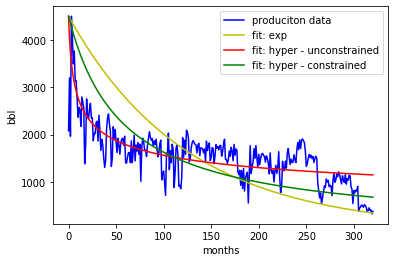

In [5]:
qi = Data['Production'].max()


popt, pcov = curve_fit(Exponential, time, series)
exp_vars = popt
popt, pcov = curve_fit(Hyperbolic, time, series)
unconstrained_vars = popt
popt, pcov = curve_fit(Hyperbolic, time, series, bounds= ([0,0], [1,5]))
constrained_vars = popt

plt.plot(time, series,'b-', label = 'produciton data')
plt.plot(time, Exponential(time, *exp_vars), 'y-', label = 'fit: exp' )
plt.plot(time, Hyperbolic(time, *unconstrained_vars), 'r-', label = 'fit: hyper - unconstrained' )
plt.plot(time, Hyperbolic(time, *constrained_vars), 'g-', label = 'fit: hyper - constrained' )
plt.xlabel('months')
plt.ylabel('bbl')
plt.legend()
plt.show()


In [161]:
ARPS_const = Hyperbolic(time, *constrained_vars)


## FB Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


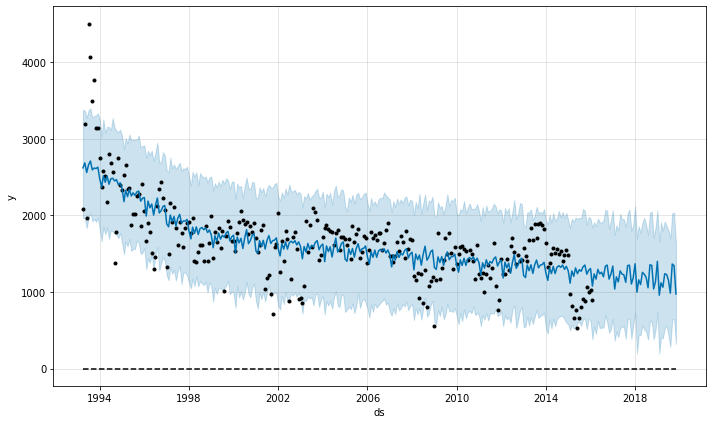

In [6]:
df = pd.DataFrame()
df['ds'] = fb_date_train
confidence = 0.95
df['y'] = x_train
df2 = df[['ds','y']]
m = Prophet(interval_width = confidence, changepoint_prior_scale = 0.05)
m.fit(df2)
future = m.make_future_dataframe(periods=45, freq = 'M')
future['cap'] = 1.0
forecast = m.predict(future)
fig = m.plot(forecast)

In [7]:
print(forecast.info())
fb_prediction_vals = forecast['yhat'].values 

fb_validation = fb_prediction_vals[split_time:]
print(len(fb_validation))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 17 columns):
ds                            320 non-null datetime64[ns]
trend                         320 non-null float64
cap                           320 non-null float64
yhat_lower                    320 non-null float64
yhat_upper                    320 non-null float64
trend_lower                   320 non-null float64
trend_upper                   320 non-null float64
additive_terms                320 non-null float64
additive_terms_lower          320 non-null float64
additive_terms_upper          320 non-null float64
yearly                        320 non-null float64
yearly_lower                  320 non-null float64
yearly_upper                  320 non-null float64
multiplicative_terms          320 non-null float64
multiplicative_terms_lower    320 non-null float64
multiplicative_terms_upper    320 non-null float64
yhat                          320 non-null float64
dtypes: datetime64[ns

## CNNs

In [8]:
# needed input format [sample, timesteps, features]
## [months, 1 month, 1 feature]

In [26]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [42]:
steps_in, steps_out = 20, 45
# generates input - output data
X, y =split_sequence(x_train, steps_in, steps_out) 
X_val, y_val = split_sequence(x_valid, steps_in, steps_out)


print(X.shape) # all data, steps in
print(y.shape) # all data, steps out
print(X_val.shape)
print(y_val.shape)

n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape) # [months, timestep in, features]

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
print(X_val.shape)

(186, 20)
(186, 45)
(7, 20)
(7, 45)
(186, 20, 1)
(7, 20, 1)


### Constructing the simplest model

In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape= (steps_in, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.LSTM(32, return_sequences=True))
model.add(keras.layers.LSTM(32, resturn_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(steps_out))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


model_checkpoint = keras.callbacks.ModelCheckpoint(r'C:\Users\Preston\Desktop\multi-step-CNN.h5')
early_stopping_CNN = keras.callbacks.EarlyStopping(patience = 50, restore_best_weights = True)

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 19, 64)            192       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 9, 32)             12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 32)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                14450     
_________________________________________________________________
dense_11 (Dense)             (None, 45)               

In [49]:
history  = model.fit(X, y, validation_data=(X_val, y_val), epochs=500, verbose=1, callbacks=[model_checkpoint, early_stopping_CNN])

Epoch 1/500
1/6 [====>.........................] - ETA: 0s - loss: 647935.0625 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 639808.3125 - accuracy: 0.0538
Epoch 2/500
1/6 [====>.........................] - ETA: 0s - loss: 657431.5625 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 640619.2500 - accuracy: 0.0538
Epoch 3/500
1/6 [====>.........................] - ETA: 0s - loss: 612291.1250 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 88ms/step - loss: 597108.5000 - accuracy: 0.0538
Epoch 4/500
1/6 [====>.........................] - ETA: 0s - loss: 534813.7500 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 569040.3125 - accuracy: 0.0538
Epoch 5/500
1/6 [====>.........................] - ETA: 0s - loss: 545302.5625 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 542440.5625 - accuracy: 0.0538
Epoch 6/500
1/6 [====>.........................] - ETA: 0s - loss: 565596.5000 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 508684.1250 - accuracy: 0.0538
Epoch 7/500
1/6 [====>.........................] - ETA: 0s - loss: 574180.1250 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 480159.7812 - accuracy: 0.0538
Epoch 8/500
1/6 [====>.........................] - ETA: 0s - loss: 510499.8750 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 452407.9688 - accuracy: 0.0538
Epoch 9/500
1/6 [====>.........................] - ETA: 0s - loss: 402768.0000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 425535.4062 - accuracy: 0.0538
Epoch 10/500
1/6 [====>.........................] - ETA: 0s - loss: 383819.4688 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 400731.6562 - accuracy: 0.0538
Epoch 11/500
1/6 [====>.........................] - ETA: 0s - loss: 370265.2500 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 368561.2500 - accuracy: 0.0538
Epoch 12/500
1/6 [====>.........................] - ETA: 0s - loss: 402981.5000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 349972.2500 - accuracy: 0.0538
Epoch 13/500
1/6 [====>.........................] - ETA: 0s - loss: 382676.0625 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 45ms/step - loss: 331350.1562 - accuracy: 0.0538
Epoch 14/500
1/6 [====>.........................] - ETA: 0s - loss: 296934.1250 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 312ms/step - loss: 306793.9688 - accuracy: 0.0538
Epoch 15/500
1/6 [====>.........................] - ETA: 0s - loss: 280419.5625 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 56ms/step - loss: 292441.7500 - accuracy: 0.0538
Epoch 16/500
1/6 [====>.........................] - ETA: 0s - loss: 298679.7500 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 268251.5312 - accuracy: 0.0538
Epoch 17/500
1/6 [====>.........................] - ETA: 0s - loss: 264603.2812 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 258070.8438 - accuracy: 0.0538
Epoch 18/500
1/6 [====>.........................] - ETA: 0s - loss: 262704.1250 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 245922.0938 - accuracy: 0.0538
Epoch 19/500
1/6 [====>.........................] - ETA: 0s - loss: 215822.5312 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 233204.4688 - accuracy: 0.0538
Epoch 20/500
1/6 [====>.........................] - ETA: 0s - loss: 230390.8750 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 219770.9688 - accuracy: 0.0538
Epoch 21/500
1/6 [====>.........................] - ETA: 0s - loss: 201400.1562 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 204446.8750 - accuracy: 0.0538
Epoch 22/500
1/6 [====>.........................] - ETA: 0s - loss: 197817.9062 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 30ms/step - loss: 200431.2031 - accuracy: 0.0538
Epoch 23/500
1/6 [====>.........................] - ETA: 0s - loss: 183946.5938 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 44ms/step - loss: 186895.9531 - accuracy: 0.0538
Epoch 24/500
1/6 [====>.........................] - ETA: 0s - loss: 178636.0625 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 237ms/step - loss: 180946.2344 - accuracy: 0.0538
Epoch 25/500
1/6 [====>.........................] - ETA: 0s - loss: 176284.0625 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 49ms/step - loss: 172537.0938 - accuracy: 0.0538
Epoch 26/500
1/6 [====>.........................] - ETA: 0s - loss: 177917.7969 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 161642.7656 - accuracy: 0.0538
Epoch 27/500
1/6 [====>.........................] - ETA: 0s - loss: 184784.5000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 163872.4688 - accuracy: 0.0538
Epoch 28/500
1/6 [====>.........................] - ETA: 0s - loss: 168982.7812 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 150270.0000 - accuracy: 0.0538
Epoch 29/500
1/6 [====>.........................] - ETA: 0s - loss: 157331.5156 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 148187.7188 - accuracy: 0.0538
Epoch 30/500
1/6 [====>.........................] - ETA: 0s - loss: 127771.0312 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 142766.9688 - accuracy: 0.0538
Epoch 31/500
1/6 [====>.........................] - ETA: 0s - loss: 140527.6875 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 29ms/step - loss: 135077.4375 - accuracy: 0.0538
Epoch 32/500
1/6 [====>.........................] - ETA: 0s - loss: 141119.5625 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 37ms/step - loss: 135989.7344 - accuracy: 0.0538
Epoch 33/500
1/6 [====>.........................] - ETA: 0s - loss: 149168.2344 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 233ms/step - loss: 133474.3438 - accuracy: 0.0538
Epoch 34/500
1/6 [====>.........................] - ETA: 0s - loss: 125834.5781 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 46ms/step - loss: 130121.9062 - accuracy: 0.0538
Epoch 35/500
1/6 [====>.........................] - ETA: 0s - loss: 133994.0000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 127364.9766 - accuracy: 0.0538
Epoch 36/500
1/6 [====>.........................] - ETA: 0s - loss: 115878.9531 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 119931.7969 - accuracy: 0.0538
Epoch 37/500
1/6 [====>.........................] - ETA: 0s - loss: 112253.7891 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 119048.6797 - accuracy: 0.0538
Epoch 38/500
1/6 [====>.........................] - ETA: 0s - loss: 119204.7422 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 121461.8828 - accuracy: 0.0538
Epoch 39/500
1/6 [====>.........................] - ETA: 0s - loss: 139289.2812 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 120785.0000 - accuracy: 0.0538
Epoch 40/500
1/6 [====>.........................] - ETA: 0s - loss: 101050.8438 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 116909.4297 - accuracy: 0.0538
Epoch 41/500
1/6 [====>.........................] - ETA: 0s - loss: 137505.5781 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 117593.3359 - accuracy: 0.0538
Epoch 42/500
1/6 [====>.........................] - ETA: 0s - loss: 109868.8438 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 250ms/step - loss: 110111.1797 - accuracy: 0.0538
Epoch 43/500
1/6 [====>.........................] - ETA: 0s - loss: 102489.6562 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 34ms/step - loss: 113177.3672 - accuracy: 0.0538
Epoch 44/500
1/6 [====>.........................] - ETA: 0s - loss: 118337.5000 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 113474.3672 - accuracy: 0.0538
Epoch 45/500
1/6 [====>.........................] - ETA: 0s - loss: 115328.0938 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 108256.8359 - accuracy: 0.0538
Epoch 46/500
1/6 [====>.........................] - ETA: 0s - loss: 113160.8281 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 108530.2188 - accuracy: 0.0538
Epoch 47/500
1/6 [====>.........................] - ETA: 0s - loss: 107672.9844 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 110297.4375 - accuracy: 0.0538
Epoch 48/500
1/6 [====>.........................] - ETA: 0s - loss: 96270.6250 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 24ms/step - loss: 108153.9141 - accuracy: 0.0538
Epoch 49/500
1/6 [====>.........................] - ETA: 0s - loss: 121991.0156 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 109632.2812 - accuracy: 0.0538
Epoch 50/500
1/6 [====>.........................] - ETA: 0s - loss: 117854.3750 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 110173.7500 - accuracy: 0.0538
Epoch 51/500
1/6 [====>.........................] - ETA: 0s - loss: 109135.4609 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107384.3047 - accuracy: 0.0538
Epoch 52/500
1/6 [====>.........................] - ETA: 0s - loss: 110578.4375 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 289ms/step - loss: 106602.7188 - accuracy: 0.0538
Epoch 53/500
1/6 [====>.........................] - ETA: 0s - loss: 103149.5938 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 52ms/step - loss: 109300.0469 - accuracy: 0.0538
Epoch 54/500
1/6 [====>.........................] - ETA: 0s - loss: 122859.7266 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 108943.0078 - accuracy: 0.0538
Epoch 55/500
1/6 [====>.........................] - ETA: 0s - loss: 103476.7500 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 104987.1719 - accuracy: 0.0538
Epoch 56/500
1/6 [====>.........................] - ETA: 0s - loss: 102729.7656 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 107082.5391 - accuracy: 0.0538
Epoch 57/500
1/6 [====>.........................] - ETA: 0s - loss: 121139.6406 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 107923.7188 - accuracy: 0.0538
Epoch 58/500
1/6 [====>.........................] - ETA: 0s - loss: 111697.3828 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103773.3438 - accuracy: 0.0538
Epoch 59/500
1/6 [====>.........................] - ETA: 0s - loss: 99493.8203 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 107398.4922 - accuracy: 0.0538
Epoch 60/500
1/6 [====>.........................] - ETA: 0s - loss: 110037.2344 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106749.5078 - accuracy: 0.0538
Epoch 61/500
1/6 [====>.........................] - ETA: 0s - loss: 105015.5156 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 108464.0000 - accuracy: 0.0538
Epoch 62/500
1/6 [====>.........................] - ETA: 0s - loss: 118527.0703 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 28ms/step - loss: 107550.7500 - accuracy: 0.0538
Epoch 63/500
1/6 [====>.........................] - ETA: 0s - loss: 110345.0625 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 55ms/step - loss: 106439.0859 - accuracy: 0.0538
Epoch 64/500
1/6 [====>.........................] - ETA: 0s - loss: 113825.2500 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 270ms/step - loss: 106091.5781 - accuracy: 0.0538
Epoch 65/500
1/6 [====>.........................] - ETA: 0s - loss: 109357.3672 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 39ms/step - loss: 105088.9219 - accuracy: 0.0538
Epoch 66/500
1/6 [====>.........................] - ETA: 0s - loss: 107802.5156 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104638.2578 - accuracy: 0.0538
Epoch 67/500
1/6 [====>.........................] - ETA: 0s - loss: 103045.7344 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 24ms/step - loss: 106664.4531 - accuracy: 0.0538
Epoch 68/500
1/6 [====>.........................] - ETA: 0s - loss: 91905.9766 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 104835.4766 - accuracy: 0.0538
Epoch 69/500
1/6 [====>.........................] - ETA: 0s - loss: 111300.4688 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105887.3906 - accuracy: 0.0538
Epoch 70/500
1/6 [====>.........................] - ETA: 0s - loss: 100055.9688 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104970.6094 - accuracy: 0.0538
Epoch 71/500
1/6 [====>.........................] - ETA: 0s - loss: 99995.1875 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105982.3672 - accuracy: 0.0538
Epoch 72/500
1/6 [====>.........................] - ETA: 0s - loss: 100210.5312 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 105731.6328 - accuracy: 0.0538
Epoch 73/500
1/6 [====>.........................] - ETA: 0s - loss: 100771.2656 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 37ms/step - loss: 107435.1406 - accuracy: 0.0538
Epoch 74/500
1/6 [====>.........................] - ETA: 0s - loss: 105224.5312 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 30ms/step - loss: 103909.3750 - accuracy: 0.0538
Epoch 75/500
1/6 [====>.........................] - ETA: 0s - loss: 107633.0469 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 221ms/step - loss: 106835.6016 - accuracy: 0.0538
Epoch 76/500
1/6 [====>.........................] - ETA: 0s - loss: 103753.4375 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 105515.7500 - accuracy: 0.0538
Epoch 77/500
1/6 [====>.........................] - ETA: 0s - loss: 110364.0391 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107501.2656 - accuracy: 0.0538
Epoch 78/500
1/6 [====>.........................] - ETA: 0s - loss: 113700.7500 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 106464.2344 - accuracy: 0.0538
Epoch 79/500
1/6 [====>.........................] - ETA: 0s - loss: 100733.6250 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105734.7812 - accuracy: 0.0538
Epoch 80/500
1/6 [====>.........................] - ETA: 0s - loss: 101102.6094 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 107030.7500 - accuracy: 0.0538
Epoch 81/500
1/6 [====>.........................] - ETA: 0s - loss: 107690.7812 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 103371.1406 - accuracy: 0.0538
Epoch 82/500
1/6 [====>.........................] - ETA: 0s - loss: 127654.6562 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 31ms/step - loss: 106450.7500 - accuracy: 0.0538
Epoch 83/500
1/6 [====>.........................] - ETA: 0s - loss: 101001.0469 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 105614.2266 - accuracy: 0.0538
Epoch 84/500
1/6 [====>.........................] - ETA: 0s - loss: 95166.9453 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105175.1172 - accuracy: 0.0538
Epoch 85/500
1/6 [====>.........................] - ETA: 0s - loss: 107367.4219 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 35ms/step - loss: 103992.0547 - accuracy: 0.0538
Epoch 86/500
1/6 [====>.........................] - ETA: 0s - loss: 105304.3828 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 28ms/step - loss: 104540.7188 - accuracy: 0.0538
Epoch 87/500
1/6 [====>.........................] - ETA: 0s - loss: 108187.7344 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 31ms/step - loss: 105147.0312 - accuracy: 0.0538
Epoch 88/500
1/6 [====>.........................] - ETA: 0s - loss: 91166.1875 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 27ms/step - loss: 104341.4766 - accuracy: 0.0538
Epoch 89/500
1/6 [====>.........................] - ETA: 0s - loss: 100117.0703 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 29ms/step - loss: 105827.7109 - accuracy: 0.0538
Epoch 90/500
1/6 [====>.........................] - ETA: 0s - loss: 102342.6719 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 30ms/step - loss: 104712.5156 - accuracy: 0.0538
Epoch 91/500
1/6 [====>.........................] - ETA: 0s - loss: 97012.8281 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 38ms/step - loss: 104925.8516 - accuracy: 0.0538
Epoch 92/500
1/6 [====>.........................] - ETA: 0s - loss: 100223.6641 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 35ms/step - loss: 105834.6875 - accuracy: 0.0538
Epoch 93/500
1/6 [====>.........................] - ETA: 0s - loss: 109444.4062 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 38ms/step - loss: 107445.5156 - accuracy: 0.0538
Epoch 94/500
1/6 [====>.........................] - ETA: 0s - loss: 103536.0156 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 46ms/step - loss: 104939.6797 - accuracy: 0.0538
Epoch 95/500
1/6 [====>.........................] - ETA: 0s - loss: 98490.3906 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 29ms/step - loss: 106147.4766 - accuracy: 0.0538
Epoch 96/500
1/6 [====>.........................] - ETA: 0s - loss: 113316.7266 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 282ms/step - loss: 106058.0547 - accuracy: 0.0538
Epoch 97/500
1/6 [====>.........................] - ETA: 0s - loss: 105258.4062 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 34ms/step - loss: 106238.8594 - accuracy: 0.0538
Epoch 98/500
1/6 [====>.........................] - ETA: 0s - loss: 105085.0156 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 63ms/step - loss: 108304.1328 - accuracy: 0.0538
Epoch 99/500
1/6 [====>.........................] - ETA: 0s - loss: 118722.2500 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 92ms/step - loss: 103671.5625 - accuracy: 0.0538
Epoch 100/500
1/6 [====>.........................] - ETA: 0s - loss: 116338.9844 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107272.7656 - accuracy: 0.0538
Epoch 101/500
1/6 [====>.........................] - ETA: 0s - loss: 94030.4219 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106388.4922 - accuracy: 0.0538
Epoch 102/500
1/6 [====>.........................] - ETA: 0s - loss: 101745.2109 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105705.7422 - accuracy: 0.0538
Epoch 103/500
1/6 [====>.........................] - ETA: 0s - loss: 109081.7031 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 105370.9062 - accuracy: 0.0538
Epoch 104/500
1/6 [====>.........................] - ETA: 0s - loss: 106006.9141 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105918.5781 - accuracy: 0.0538
Epoch 105/500
1/6 [====>.........................] - ETA: 0s - loss: 91224.5938 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107918.1484 - accuracy: 0.0538
Epoch 106/500
1/6 [====>.........................] - ETA: 0s - loss: 98337.2500 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 102719.7656 - accuracy: 0.0538
Epoch 107/500
1/6 [====>.........................] - ETA: 0s - loss: 113804.0000 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 108119.1797 - accuracy: 0.0538
Epoch 108/500
1/6 [====>.........................] - ETA: 0s - loss: 118683.5703 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 305ms/step - loss: 107842.0469 - accuracy: 0.0538
Epoch 109/500
1/6 [====>.........................] - ETA: 0s - loss: 111171.9453 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105078.9375 - accuracy: 0.0538
Epoch 110/500
1/6 [====>.........................] - ETA: 0s - loss: 100996.1250 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 100814.8828 - accuracy: 0.0538
Epoch 111/500
1/6 [====>.........................] - ETA: 0s - loss: 96986.4688 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 106302.9062 - accuracy: 0.0538
Epoch 112/500
1/6 [====>.........................] - ETA: 0s - loss: 108592.8594 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 108273.8281 - accuracy: 0.0538
Epoch 113/500
1/6 [====>.........................] - ETA: 0s - loss: 108714.5000 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104192.8594 - accuracy: 0.0538
Epoch 114/500
1/6 [====>.........................] - ETA: 0s - loss: 102533.3359 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105140.5625 - accuracy: 0.0538
Epoch 115/500
1/6 [====>.........................] - ETA: 0s - loss: 98876.7500 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 104724.1172 - accuracy: 0.0538
Epoch 116/500
1/6 [====>.........................] - ETA: 0s - loss: 104888.9375 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 41ms/step - loss: 102816.1953 - accuracy: 0.0538
Epoch 117/500
1/6 [====>.........................] - ETA: 0s - loss: 112384.9375 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 227ms/step - loss: 102642.3203 - accuracy: 0.0538
Epoch 118/500
1/6 [====>.........................] - ETA: 0s - loss: 103527.3281 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104028.8359 - accuracy: 0.0538
Epoch 119/500
1/6 [====>.........................] - ETA: 0s - loss: 103254.4609 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105802.2500 - accuracy: 0.0538
Epoch 120/500
1/6 [====>.........................] - ETA: 0s - loss: 105462.7344 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 104257.8281 - accuracy: 0.0538
Epoch 121/500
1/6 [====>.........................] - ETA: 0s - loss: 110089.8750 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 108074.9922 - accuracy: 0.0538
Epoch 122/500
1/6 [====>.........................] - ETA: 0s - loss: 97459.0000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 103691.6016 - accuracy: 0.0538
Epoch 123/500
1/6 [====>.........................] - ETA: 0s - loss: 105563.6250 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 32ms/step - loss: 108447.7344 - accuracy: 0.0538
Epoch 124/500
1/6 [====>.........................] - ETA: 0s - loss: 102847.0156 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 198ms/step - loss: 102832.3359 - accuracy: 0.0538
Epoch 125/500
1/6 [====>.........................] - ETA: 0s - loss: 110185.9531 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 81ms/step - loss: 107327.3906 - accuracy: 0.0538
Epoch 126/500
1/6 [====>.........................] - ETA: 0s - loss: 103974.2031 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 104518.1094 - accuracy: 0.0538
Epoch 127/500
1/6 [====>.........................] - ETA: 0s - loss: 108259.4375 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 107936.9375 - accuracy: 0.0538
Epoch 128/500
1/6 [====>.........................] - ETA: 0s - loss: 101701.7266 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 106071.1406 - accuracy: 0.0538
Epoch 129/500
1/6 [====>.........................] - ETA: 0s - loss: 91282.2656 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 102930.9922 - accuracy: 0.0538
Epoch 130/500
1/6 [====>.........................] - ETA: 0s - loss: 110832.7188 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 104265.9531 - accuracy: 0.0538
Epoch 131/500
1/6 [====>.........................] - ETA: 0s - loss: 100284.3750 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 103342.9375 - accuracy: 0.0538
Epoch 132/500
1/6 [====>.........................] - ETA: 0s - loss: 110223.5156 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 104347.2188 - accuracy: 0.0538
Epoch 133/500
1/6 [====>.........................] - ETA: 0s - loss: 114801.0391 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 275ms/step - loss: 107381.9375 - accuracy: 0.0538
Epoch 134/500
1/6 [====>.........................] - ETA: 0s - loss: 118036.4453 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105146.6250 - accuracy: 0.0538
Epoch 135/500
1/6 [====>.........................] - ETA: 0s - loss: 121702.3281 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 106815.2656 - accuracy: 0.0538
Epoch 136/500
1/6 [====>.........................] - ETA: 0s - loss: 104271.5078 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 25ms/step - loss: 106353.5078 - accuracy: 0.0538
Epoch 137/500
1/6 [====>.........................] - ETA: 0s - loss: 111505.0312 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105344.7188 - accuracy: 0.0538
Epoch 138/500
1/6 [====>.........................] - ETA: 0s - loss: 93925.6484 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 105186.6484 - accuracy: 0.0538
Epoch 139/500
1/6 [====>.........................] - ETA: 0s - loss: 115829.1094 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 104615.0859 - accuracy: 0.0538
Epoch 140/500
1/6 [====>.........................] - ETA: 0s - loss: 104839.2422 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 31ms/step - loss: 102841.6797 - accuracy: 0.0538
Epoch 141/500
1/6 [====>.........................] - ETA: 0s - loss: 100120.2188 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 107794.6953 - accuracy: 0.0538
Epoch 142/500
1/6 [====>.........................] - ETA: 0s - loss: 99560.7500 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 105466.4297 - accuracy: 0.0538
Epoch 143/500
1/6 [====>.........................] - ETA: 0s - loss: 98407.1250 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 204ms/step - loss: 102545.3125 - accuracy: 0.0538
Epoch 144/500
1/6 [====>.........................] - ETA: 0s - loss: 112861.9766 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106721.1719 - accuracy: 0.0538
Epoch 145/500
1/6 [====>.........................] - ETA: 0s - loss: 98928.8125 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 77ms/step - loss: 106763.3750 - accuracy: 0.0538
Epoch 146/500
1/6 [====>.........................] - ETA: 0s - loss: 98662.5391 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 103698.8047 - accuracy: 0.0538
Epoch 147/500
1/6 [====>.........................] - ETA: 0s - loss: 110102.6562 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 108264.1953 - accuracy: 0.0538
Epoch 148/500
1/6 [====>.........................] - ETA: 0s - loss: 101171.0859 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 103702.2812 - accuracy: 0.0538
Epoch 149/500
1/6 [====>.........................] - ETA: 0s - loss: 108737.7812 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 105506.4219 - accuracy: 0.0538
Epoch 150/500
1/6 [====>.........................] - ETA: 0s - loss: 123783.3594 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105040.1797 - accuracy: 0.0538
Epoch 151/500
1/6 [====>.........................] - ETA: 0s - loss: 96952.0938 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105025.8906 - accuracy: 0.0538
Epoch 152/500
1/6 [====>.........................] - ETA: 0s - loss: 109722.1875 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 107538.6484 - accuracy: 0.0538
Epoch 153/500
1/6 [====>.........................] - ETA: 0s - loss: 117323.1094 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 107464.0781 - accuracy: 0.0538
Epoch 154/500
1/6 [====>.........................] - ETA: 0s - loss: 122808.3594 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 43ms/step - loss: 107833.9922 - accuracy: 0.0538
Epoch 155/500
1/6 [====>.........................] - ETA: 0s - loss: 92540.7188 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 38ms/step - loss: 102989.5156 - accuracy: 0.0538
Epoch 156/500
1/6 [====>.........................] - ETA: 0s - loss: 104810.7188 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 34ms/step - loss: 106764.0078 - accuracy: 0.0538
Epoch 157/500
1/6 [====>.........................] - ETA: 0s - loss: 99152.0938 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 106196.7734 - accuracy: 0.0538
Epoch 158/500
1/6 [====>.........................] - ETA: 0s - loss: 96265.5781 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 29ms/step - loss: 104147.3203 - accuracy: 0.0538
Epoch 159/500
1/6 [====>.........................] - ETA: 0s - loss: 107737.5156 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 283ms/step - loss: 103215.4609 - accuracy: 0.0538
Epoch 160/500
1/6 [====>.........................] - ETA: 0s - loss: 121218.3672 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 107003.4922 - accuracy: 0.0538
Epoch 161/500
1/6 [====>.........................] - ETA: 0s - loss: 89336.8672 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105569.0781 - accuracy: 0.0538
Epoch 162/500
1/6 [====>.........................] - ETA: 0s - loss: 104133.4531 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 105180.8047 - accuracy: 0.0538
Epoch 163/500
1/6 [====>.........................] - ETA: 0s - loss: 105636.9688 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 140ms/step - loss: 103920.8203 - accuracy: 0.0538
Epoch 164/500
1/6 [====>.........................] - ETA: 0s - loss: 105444.7344 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 104435.6484 - accuracy: 0.0538
Epoch 165/500
1/6 [====>.........................] - ETA: 0s - loss: 100011.2266 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 107895.3203 - accuracy: 0.0538
Epoch 166/500
1/6 [====>.........................] - ETA: 0s - loss: 114664.2656 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 81ms/step - loss: 105119.3750 - accuracy: 0.0538
Epoch 167/500
1/6 [====>.........................] - ETA: 0s - loss: 108343.0312 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 109265.7344 - accuracy: 0.0538
Epoch 168/500
1/6 [====>.........................] - ETA: 0s - loss: 101145.5703 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106668.1094 - accuracy: 0.0538
Epoch 169/500
1/6 [====>.........................] - ETA: 0s - loss: 112890.7656 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 102519.3750 - accuracy: 0.0538
Epoch 170/500
1/6 [====>.........................] - ETA: 0s - loss: 106080.7188 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 108017.2188 - accuracy: 0.0538
Epoch 171/500
1/6 [====>.........................] - ETA: 0s - loss: 105358.6797 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 181ms/step - loss: 106536.6250 - accuracy: 0.0538
Epoch 172/500
1/6 [====>.........................] - ETA: 0s - loss: 109242.1875 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 24ms/step - loss: 104649.6641 - accuracy: 0.0538
Epoch 173/500
1/6 [====>.........................] - ETA: 0s - loss: 109850.6875 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107414.6562 - accuracy: 0.0538
Epoch 174/500
1/6 [====>.........................] - ETA: 0s - loss: 116229.1328 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 102828.3750 - accuracy: 0.0538
Epoch 175/500
1/6 [====>.........................] - ETA: 0s - loss: 112292.0547 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106042.4531 - accuracy: 0.0538
Epoch 176/500
1/6 [====>.........................] - ETA: 0s - loss: 108615.0312 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104250.6875 - accuracy: 0.0538
Epoch 177/500
1/6 [====>.........................] - ETA: 0s - loss: 118393.6406 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 218ms/step - loss: 108983.1484 - accuracy: 0.0538
Epoch 178/500
1/6 [====>.........................] - ETA: 0s - loss: 108537.9375 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 104072.3359 - accuracy: 0.0538
Epoch 179/500
1/6 [====>.........................] - ETA: 0s - loss: 100979.9688 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 121ms/step - loss: 105916.8828 - accuracy: 0.0538
Epoch 180/500
1/6 [====>.........................] - ETA: 0s - loss: 109118.9531 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105659.9766 - accuracy: 0.0538
Epoch 181/500
1/6 [====>.........................] - ETA: 0s - loss: 110805.0469 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103119.7188 - accuracy: 0.0538
Epoch 182/500
1/6 [====>.........................] - ETA: 0s - loss: 88283.5312 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103361.7188 - accuracy: 0.0538
Epoch 183/500
1/6 [====>.........................] - ETA: 0s - loss: 113154.3359 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106878.7344 - accuracy: 0.0538
Epoch 184/500
1/6 [====>.........................] - ETA: 0s - loss: 102717.9375 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106535.1172 - accuracy: 0.0538
Epoch 185/500
1/6 [====>.........................] - ETA: 0s - loss: 112309.4141 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 106880.2344 - accuracy: 0.0538
Epoch 186/500
1/6 [====>.........................] - ETA: 0s - loss: 108278.6484 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 100964.7812 - accuracy: 0.0538
Epoch 187/500
1/6 [====>.........................] - ETA: 0s - loss: 92024.0938 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 32ms/step - loss: 105320.3047 - accuracy: 0.0538
Epoch 188/500
1/6 [====>.........................] - ETA: 0s - loss: 105231.1641 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 40ms/step - loss: 103921.6328 - accuracy: 0.0538
Epoch 189/500
1/6 [====>.........................] - ETA: 0s - loss: 103664.5781 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 283ms/step - loss: 106158.7500 - accuracy: 0.0538
Epoch 190/500
1/6 [====>.........................] - ETA: 0s - loss: 108923.8438 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105880.8594 - accuracy: 0.0538
Epoch 191/500
1/6 [====>.........................] - ETA: 0s - loss: 103490.6875 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104905.3047 - accuracy: 0.0538
Epoch 192/500
1/6 [====>.........................] - ETA: 0s - loss: 109336.2969 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 104826.9141 - accuracy: 0.0538
Epoch 193/500
1/6 [====>.........................] - ETA: 0s - loss: 84061.8906 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105268.4062 - accuracy: 0.0538
Epoch 194/500
1/6 [====>.........................] - ETA: 0s - loss: 108190.2422 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 103552.5391 - accuracy: 0.0538
Epoch 195/500
1/6 [====>.........................] - ETA: 0s - loss: 98141.7969 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 107331.5078 - accuracy: 0.0538
Epoch 196/500
1/6 [====>.........................] - ETA: 0s - loss: 105241.5391 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103765.9531 - accuracy: 0.0538
Epoch 197/500
1/6 [====>.........................] - ETA: 0s - loss: 105250.9609 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105408.4844 - accuracy: 0.0538
Epoch 198/500
1/6 [====>.........................] - ETA: 0s - loss: 120261.0938 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 40ms/step - loss: 110194.6641 - accuracy: 0.0538
Epoch 199/500
1/6 [====>.........................] - ETA: 0s - loss: 117739.0000 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 32ms/step - loss: 108961.6953 - accuracy: 0.0538
Epoch 200/500
1/6 [====>.........................] - ETA: 0s - loss: 122392.9453 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 27ms/step - loss: 104369.3750 - accuracy: 0.0538
Epoch 201/500
1/6 [====>.........................] - ETA: 0s - loss: 97595.2266 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 29ms/step - loss: 103483.8281 - accuracy: 0.0538
Epoch 202/500
1/6 [====>.........................] - ETA: 0s - loss: 107456.1094 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 34ms/step - loss: 107851.2656 - accuracy: 0.0538
Epoch 203/500
1/6 [====>.........................] - ETA: 0s - loss: 100961.8359 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 29ms/step - loss: 108333.4609 - accuracy: 0.0538
Epoch 204/500
1/6 [====>.........................] - ETA: 0s - loss: 106024.2812 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 222ms/step - loss: 106857.9531 - accuracy: 0.0538
Epoch 205/500
1/6 [====>.........................] - ETA: 0s - loss: 93008.6172 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 72ms/step - loss: 105204.6641 - accuracy: 0.0538
Epoch 206/500
1/6 [====>.........................] - ETA: 0s - loss: 103782.1719 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107021.0859 - accuracy: 0.0538
Epoch 207/500
1/6 [====>.........................] - ETA: 0s - loss: 111636.6953 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 83ms/step - loss: 105415.9531 - accuracy: 0.0538
Epoch 208/500
1/6 [====>.........................] - ETA: 0s - loss: 104890.3594 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106158.9062 - accuracy: 0.0538
Epoch 209/500
1/6 [====>.........................] - ETA: 0s - loss: 96052.2578 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107331.8594 - accuracy: 0.0538
Epoch 210/500
1/6 [====>.........................] - ETA: 0s - loss: 111378.2734 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106518.9766 - accuracy: 0.0538
Epoch 211/500
1/6 [====>.........................] - ETA: 0s - loss: 114368.6875 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 106682.0469 - accuracy: 0.0538
Epoch 212/500
1/6 [====>.........................] - ETA: 0s - loss: 112092.5547 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 209ms/step - loss: 105126.1094 - accuracy: 0.0538
Epoch 213/500
1/6 [====>.........................] - ETA: 0s - loss: 99281.5781 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 104145.3125 - accuracy: 0.0538
Epoch 214/500
1/6 [====>.........................] - ETA: 0s - loss: 108119.3516 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105844.4219 - accuracy: 0.0538
Epoch 215/500
1/6 [====>.........................] - ETA: 0s - loss: 98979.1875 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 105434.3047 - accuracy: 0.0538
Epoch 216/500
1/6 [====>.........................] - ETA: 0s - loss: 118831.0547 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 105561.3984 - accuracy: 0.0538
Epoch 217/500
1/6 [====>.........................] - ETA: 0s - loss: 106755.3281 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 108304.7109 - accuracy: 0.0538
Epoch 218/500
1/6 [====>.........................] - ETA: 0s - loss: 109805.9844 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 106938.3438 - accuracy: 0.0538
Epoch 219/500
1/6 [====>.........................] - ETA: 0s - loss: 102387.3438 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 162ms/step - loss: 105536.9766 - accuracy: 0.0538
Epoch 220/500
1/6 [====>.........................] - ETA: 0s - loss: 114463.9219 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106428.7188 - accuracy: 0.0538
Epoch 221/500
1/6 [====>.........................] - ETA: 0s - loss: 110270.4688 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 109ms/step - loss: 106828.4062 - accuracy: 0.0538
Epoch 222/500
1/6 [====>.........................] - ETA: 0s - loss: 96407.6094 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 106519.8203 - accuracy: 0.0538
Epoch 223/500
1/6 [====>.........................] - ETA: 0s - loss: 112423.2656 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105838.3984 - accuracy: 0.0538
Epoch 224/500
1/6 [====>.........................] - ETA: 0s - loss: 93880.8750 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 94ms/step - loss: 105088.0312 - accuracy: 0.0538
Epoch 225/500
1/6 [====>.........................] - ETA: 0s - loss: 106120.4141 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 107009.2031 - accuracy: 0.0538
Epoch 226/500
1/6 [====>.........................] - ETA: 0s - loss: 102956.0156 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106391.3906 - accuracy: 0.0538
Epoch 227/500
1/6 [====>.........................] - ETA: 0s - loss: 100248.1250 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 102978.8594 - accuracy: 0.0538
Epoch 228/500
1/6 [====>.........................] - ETA: 0s - loss: 117340.3750 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 106677.9219 - accuracy: 0.0538
Epoch 229/500
1/6 [====>.........................] - ETA: 0s - loss: 111151.3594 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 195ms/step - loss: 102113.3750 - accuracy: 0.0538
Epoch 230/500
1/6 [====>.........................] - ETA: 0s - loss: 100437.4453 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 103059.2188 - accuracy: 0.0538
Epoch 231/500
1/6 [====>.........................] - ETA: 0s - loss: 106296.0781 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 104768.7969 - accuracy: 0.0538
Epoch 232/500
1/6 [====>.........................] - ETA: 0s - loss: 111253.9062 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 24ms/step - loss: 103039.4062 - accuracy: 0.0538
Epoch 233/500
1/6 [====>.........................] - ETA: 0s - loss: 98556.5469 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 104017.5391 - accuracy: 0.0538
Epoch 234/500
1/6 [====>.........................] - ETA: 0s - loss: 115774.0938 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 14ms/step - loss: 106676.3516 - accuracy: 0.0538
Epoch 235/500
1/6 [====>.........................] - ETA: 0s - loss: 115593.8125 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 14ms/step - loss: 103537.5781 - accuracy: 0.0538
Epoch 236/500
1/6 [====>.........................] - ETA: 0s - loss: 96016.7578 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 106115.7656 - accuracy: 0.0538
Epoch 237/500
1/6 [====>.........................] - ETA: 0s - loss: 104611.8203 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 31ms/step - loss: 105514.6094 - accuracy: 0.0538
Epoch 238/500
1/6 [====>.........................] - ETA: 0s - loss: 106410.1875 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 30ms/step - loss: 104019.6562 - accuracy: 0.0538
Epoch 239/500
1/6 [====>.........................] - ETA: 0s - loss: 94961.5469 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 105786.1797 - accuracy: 0.0538
Epoch 240/500
1/6 [====>.........................] - ETA: 0s - loss: 106498.2578 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 28ms/step - loss: 105776.8672 - accuracy: 0.0538
Epoch 241/500
1/6 [====>.........................] - ETA: 0s - loss: 96983.9219 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 38ms/step - loss: 106767.9766 - accuracy: 0.0538
Epoch 242/500
1/6 [====>.........................] - ETA: 0s - loss: 103173.7812 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 35ms/step - loss: 106876.6328 - accuracy: 0.0538
Epoch 243/500
1/6 [====>.........................] - ETA: 0s - loss: 105430.2812 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 310ms/step - loss: 103573.3906 - accuracy: 0.0538
Epoch 244/500
1/6 [====>.........................] - ETA: 0s - loss: 105920.6797 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 106842.7109 - accuracy: 0.0538
Epoch 245/500
1/6 [====>.........................] - ETA: 0s - loss: 105355.7969 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 27ms/step - loss: 103828.8047 - accuracy: 0.0538
Epoch 246/500
1/6 [====>.........................] - ETA: 0s - loss: 109461.5156 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 151ms/step - loss: 108369.6875 - accuracy: 0.0538
Epoch 247/500
1/6 [====>.........................] - ETA: 0s - loss: 105440.5469 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107510.6328 - accuracy: 0.0538
Epoch 248/500
1/6 [====>.........................] - ETA: 0s - loss: 103225.3594 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105688.0078 - accuracy: 0.0538
Epoch 249/500
1/6 [====>.........................] - ETA: 0s - loss: 107261.5391 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 105364.9141 - accuracy: 0.0538
Epoch 250/500
1/6 [====>.........................] - ETA: 0s - loss: 104793.3281 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 211ms/step - loss: 105094.4219 - accuracy: 0.0538
Epoch 251/500
1/6 [====>.........................] - ETA: 0s - loss: 105950.9531 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 104932.8594 - accuracy: 0.0538
Epoch 252/500
1/6 [====>.........................] - ETA: 0s - loss: 99793.3281 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 103271.7734 - accuracy: 0.0538
Epoch 253/500
1/6 [====>.........................] - ETA: 0s - loss: 99828.5000 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107287.6875 - accuracy: 0.0538
Epoch 254/500
1/6 [====>.........................] - ETA: 0s - loss: 107420.2734 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 105243.1641 - accuracy: 0.0538
Epoch 255/500
1/6 [====>.........................] - ETA: 0s - loss: 116588.7422 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 105801.4531 - accuracy: 0.0538
Epoch 256/500
1/6 [====>.........................] - ETA: 0s - loss: 93028.4141 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107294.2031 - accuracy: 0.0538
Epoch 257/500
1/6 [====>.........................] - ETA: 0s - loss: 100269.5859 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 104958.3359 - accuracy: 0.0538
Epoch 258/500
1/6 [====>.........................] - ETA: 0s - loss: 114117.3203 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106012.5469 - accuracy: 0.0538
Epoch 259/500
1/6 [====>.........................] - ETA: 0s - loss: 114970.6562 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 106802.7500 - accuracy: 0.0538
Epoch 260/500
1/6 [====>.........................] - ETA: 0s - loss: 101376.8281 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 326ms/step - loss: 102340.3203 - accuracy: 0.0538
Epoch 261/500
1/6 [====>.........................] - ETA: 0s - loss: 107620.4766 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 88ms/step - loss: 103349.6797 - accuracy: 0.0538
Epoch 262/500
1/6 [====>.........................] - ETA: 0s - loss: 98459.0781 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 103372.8281 - accuracy: 0.0538
Epoch 263/500
1/6 [====>.........................] - ETA: 0s - loss: 102015.9688 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105762.8594 - accuracy: 0.0538
Epoch 264/500
1/6 [====>.........................] - ETA: 0s - loss: 104474.9062 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107180.2656 - accuracy: 0.0538
Epoch 265/500
1/6 [====>.........................] - ETA: 0s - loss: 96600.9219 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 147ms/step - loss: 107035.2500 - accuracy: 0.0538
Epoch 266/500
1/6 [====>.........................] - ETA: 0s - loss: 116811.9922 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 104087.8047 - accuracy: 0.0538
Epoch 267/500
1/6 [====>.........................] - ETA: 0s - loss: 115143.4922 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 108850.9219 - accuracy: 0.0538
Epoch 268/500
1/6 [====>.........................] - ETA: 0s - loss: 95758.8516 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 120ms/step - loss: 101752.8203 - accuracy: 0.0538
Epoch 269/500
1/6 [====>.........................] - ETA: 0s - loss: 98080.1484 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 104705.6094 - accuracy: 0.0538
Epoch 270/500
1/6 [====>.........................] - ETA: 0s - loss: 104098.7656 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 103719.3203 - accuracy: 0.0538
Epoch 271/500
1/6 [====>.........................] - ETA: 0s - loss: 100193.0625 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 102194.5156 - accuracy: 0.0538
Epoch 272/500
1/6 [====>.........................] - ETA: 0s - loss: 116954.2812 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 107261.8203 - accuracy: 0.0538
Epoch 273/500
1/6 [====>.........................] - ETA: 0s - loss: 99177.5781 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105781.8047 - accuracy: 0.0538
Epoch 274/500
1/6 [====>.........................] - ETA: 0s - loss: 98650.7500 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 104100.3672 - accuracy: 0.0538
Epoch 275/500
1/6 [====>.........................] - ETA: 0s - loss: 97525.4375 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107611.1406 - accuracy: 0.0538
Epoch 276/500
1/6 [====>.........................] - ETA: 0s - loss: 86607.8906 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 261ms/step - loss: 101775.1719 - accuracy: 0.0538
Epoch 277/500
1/6 [====>.........................] - ETA: 0s - loss: 106410.5469 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106384.0625 - accuracy: 0.0538
Epoch 278/500
1/6 [====>.........................] - ETA: 0s - loss: 106791.3984 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104551.5703 - accuracy: 0.0538
Epoch 279/500
1/6 [====>.........................] - ETA: 0s - loss: 106148.8281 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 104299.3516 - accuracy: 0.0538
Epoch 280/500
1/6 [====>.........................] - ETA: 0s - loss: 109158.6406 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105114.9062 - accuracy: 0.0538
Epoch 281/500
1/6 [====>.........................] - ETA: 0s - loss: 102681.2422 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 103186.9219 - accuracy: 0.0538
Epoch 282/500
1/6 [====>.........................] - ETA: 0s - loss: 110769.0312 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107304.0234 - accuracy: 0.0538
Epoch 283/500
1/6 [====>.........................] - ETA: 0s - loss: 100131.1094 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 233ms/step - loss: 106236.4375 - accuracy: 0.0538
Epoch 284/500
1/6 [====>.........................] - ETA: 0s - loss: 113820.3125 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 65ms/step - loss: 107321.6016 - accuracy: 0.0538
Epoch 285/500
1/6 [====>.........................] - ETA: 0s - loss: 102168.4531 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 105991.0312 - accuracy: 0.0538
Epoch 286/500
1/6 [====>.........................] - ETA: 0s - loss: 102434.1562 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105332.0312 - accuracy: 0.0538
Epoch 287/500
1/6 [====>.........................] - ETA: 0s - loss: 107857.0312 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106243.6797 - accuracy: 0.0538
Epoch 288/500
1/6 [====>.........................] - ETA: 0s - loss: 101658.1328 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103538.2344 - accuracy: 0.0538
Epoch 289/500
1/6 [====>.........................] - ETA: 0s - loss: 96657.7812 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 134ms/step - loss: 102920.0000 - accuracy: 0.0538
Epoch 290/500
1/6 [====>.........................] - ETA: 0s - loss: 118475.6797 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 107719.2891 - accuracy: 0.0538
Epoch 291/500
1/6 [====>.........................] - ETA: 0s - loss: 111388.8281 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 106881.4297 - accuracy: 0.0538
Epoch 292/500
1/6 [====>.........................] - ETA: 0s - loss: 102331.3203 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 104156.2344 - accuracy: 0.0538
Epoch 293/500
1/6 [====>.........................] - ETA: 0s - loss: 110492.1250 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 107336.9688 - accuracy: 0.0538
Epoch 294/500
1/6 [====>.........................] - ETA: 0s - loss: 111647.9062 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 104694.7344 - accuracy: 0.0538
Epoch 295/500
1/6 [====>.........................] - ETA: 0s - loss: 106292.6719 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 186ms/step - loss: 106669.5469 - accuracy: 0.0538
Epoch 296/500
1/6 [====>.........................] - ETA: 0s - loss: 108361.4531 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 106089.1328 - accuracy: 0.0538
Epoch 297/500
1/6 [====>.........................] - ETA: 0s - loss: 100305.8438 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105179.9688 - accuracy: 0.0538
Epoch 298/500
1/6 [====>.........................] - ETA: 0s - loss: 102491.3438 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 104997.6953 - accuracy: 0.0538
Epoch 299/500
1/6 [====>.........................] - ETA: 0s - loss: 97459.1172 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 147ms/step - loss: 109735.7734 - accuracy: 0.0538
Epoch 300/500
1/6 [====>.........................] - ETA: 0s - loss: 81474.7578 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104222.4062 - accuracy: 0.0538
Epoch 301/500
1/6 [====>.........................] - ETA: 0s - loss: 114578.5000 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 108695.6328 - accuracy: 0.0538
Epoch 302/500
1/6 [====>.........................] - ETA: 0s - loss: 109697.0625 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105964.7422 - accuracy: 0.0538
Epoch 303/500
1/6 [====>.........................] - ETA: 0s - loss: 113199.2188 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 106560.3906 - accuracy: 0.0538
Epoch 304/500
1/6 [====>.........................] - ETA: 0s - loss: 105053.3125 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 13ms/step - loss: 104416.0781 - accuracy: 0.0538
Epoch 305/500
1/6 [====>.........................] - ETA: 0s - loss: 112415.0000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 14ms/step - loss: 106835.1484 - accuracy: 0.0538
Epoch 306/500
1/6 [====>.........................] - ETA: 0s - loss: 108835.3828 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 104965.6641 - accuracy: 0.0538
Epoch 307/500
1/6 [====>.........................] - ETA: 0s - loss: 105720.7734 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 30ms/step - loss: 103038.6875 - accuracy: 0.0538
Epoch 308/500
1/6 [====>.........................] - ETA: 0s - loss: 94782.5469 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 104631.0234 - accuracy: 0.0538
Epoch 309/500
1/6 [====>.........................] - ETA: 0s - loss: 113087.9062 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 257ms/step - loss: 105689.6328 - accuracy: 0.0538
Epoch 310/500
1/6 [====>.........................] - ETA: 0s - loss: 105142.0469 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 40ms/step - loss: 106312.3516 - accuracy: 0.0538
Epoch 311/500
1/6 [====>.........................] - ETA: 0s - loss: 100730.5312 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 95ms/step - loss: 103163.9766 - accuracy: 0.0538
Epoch 312/500
1/6 [====>.........................] - ETA: 0s - loss: 96701.5234 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 102059.7812 - accuracy: 0.0538
Epoch 313/500
1/6 [====>.........................] - ETA: 0s - loss: 87917.2500 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 93ms/step - loss: 102968.8672 - accuracy: 0.0538
Epoch 314/500
1/6 [====>.........................] - ETA: 0s - loss: 103999.1719 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 103276.8594 - accuracy: 0.0538
Epoch 315/500
1/6 [====>.........................] - ETA: 0s - loss: 108704.9219 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 104166.0469 - accuracy: 0.0538
Epoch 316/500
1/6 [====>.........................] - ETA: 0s - loss: 103457.2812 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106708.6875 - accuracy: 0.0538
Epoch 317/500
1/6 [====>.........................] - ETA: 0s - loss: 107891.2656 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 25ms/step - loss: 107667.1641 - accuracy: 0.0538
Epoch 318/500
1/6 [====>.........................] - ETA: 0s - loss: 108333.5625 - accuracy: 0.1875WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105126.5391 - accuracy: 0.0538
Epoch 319/500
1/6 [====>.........................] - ETA: 0s - loss: 109019.3672 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 104502.1953 - accuracy: 0.0538
Epoch 320/500
1/6 [====>.........................] - ETA: 0s - loss: 111504.9375 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104942.2656 - accuracy: 0.0538
Epoch 321/500
1/6 [====>.........................] - ETA: 0s - loss: 101155.3672 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 102400.1484 - accuracy: 0.0538
Epoch 322/500
1/6 [====>.........................] - ETA: 0s - loss: 110633.6094 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 284ms/step - loss: 108859.0938 - accuracy: 0.0538
Epoch 323/500
1/6 [====>.........................] - ETA: 0s - loss: 102944.8594 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 107594.8359 - accuracy: 0.0538
Epoch 324/500
1/6 [====>.........................] - ETA: 0s - loss: 107964.2109 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 103848.6641 - accuracy: 0.0538
Epoch 325/500
1/6 [====>.........................] - ETA: 0s - loss: 103579.4219 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 147ms/step - loss: 106501.8047 - accuracy: 0.0538
Epoch 326/500
1/6 [====>.........................] - ETA: 0s - loss: 113486.6797 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 32ms/step - loss: 107115.8828 - accuracy: 0.0538
Epoch 327/500
1/6 [====>.........................] - ETA: 0s - loss: 106304.3828 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 48ms/step - loss: 107857.0078 - accuracy: 0.0538
Epoch 328/500
1/6 [====>.........................] - ETA: 0s - loss: 102185.9219 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 106382.9141 - accuracy: 0.0538
Epoch 329/500
1/6 [====>.........................] - ETA: 0s - loss: 97211.9766 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 31ms/step - loss: 106606.3438 - accuracy: 0.0538
Epoch 330/500
1/6 [====>.........................] - ETA: 0s - loss: 92978.1641 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 107071.5625 - accuracy: 0.0538
Epoch 331/500
1/6 [====>.........................] - ETA: 0s - loss: 115669.7656 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 137ms/step - loss: 107507.7422 - accuracy: 0.0538
Epoch 332/500
1/6 [====>.........................] - ETA: 0s - loss: 105765.0469 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106820.8203 - accuracy: 0.0538
Epoch 333/500
1/6 [====>.........................] - ETA: 0s - loss: 107499.8516 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 108526.0078 - accuracy: 0.0538
Epoch 334/500
1/6 [====>.........................] - ETA: 0s - loss: 99826.5469 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 103976.8516 - accuracy: 0.0538
Epoch 335/500
1/6 [====>.........................] - ETA: 0s - loss: 118537.8672 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104753.2812 - accuracy: 0.0538
Epoch 336/500
1/6 [====>.........................] - ETA: 0s - loss: 115144.3125 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 104099.0312 - accuracy: 0.0538
Epoch 337/500
1/6 [====>.........................] - ETA: 0s - loss: 101609.7266 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105758.8047 - accuracy: 0.0538
Epoch 338/500
1/6 [====>.........................] - ETA: 0s - loss: 110997.7344 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 103316.4219 - accuracy: 0.0538
Epoch 339/500
1/6 [====>.........................] - ETA: 0s - loss: 108450.8125 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 105349.6797 - accuracy: 0.0538
Epoch 340/500
1/6 [====>.........................] - ETA: 0s - loss: 112331.4375 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 340ms/step - loss: 105972.1328 - accuracy: 0.0538
Epoch 341/500
1/6 [====>.........................] - ETA: 0s - loss: 109534.6719 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105242.9453 - accuracy: 0.0538
Epoch 342/500
1/6 [====>.........................] - ETA: 0s - loss: 108935.9375 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103612.3984 - accuracy: 0.0538
Epoch 343/500
1/6 [====>.........................] - ETA: 0s - loss: 101186.8906 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 108663.3516 - accuracy: 0.0538
Epoch 344/500
1/6 [====>.........................] - ETA: 0s - loss: 101894.7812 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 142ms/step - loss: 105655.5078 - accuracy: 0.0538
Epoch 345/500
1/6 [====>.........................] - ETA: 0s - loss: 104489.1250 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 94ms/step - loss: 102707.6484 - accuracy: 0.0538
Epoch 346/500
1/6 [====>.........................] - ETA: 0s - loss: 100577.9688 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 102466.2344 - accuracy: 0.0538
Epoch 347/500
1/6 [====>.........................] - ETA: 0s - loss: 114079.5000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 109314.6016 - accuracy: 0.0538
Epoch 348/500
1/6 [====>.........................] - ETA: 0s - loss: 106647.9531 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105693.3516 - accuracy: 0.0538
Epoch 349/500
1/6 [====>.........................] - ETA: 0s - loss: 99832.7500 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 104983.8281 - accuracy: 0.0538
Epoch 350/500
1/6 [====>.........................] - ETA: 0s - loss: 106498.3438 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104355.4609 - accuracy: 0.0538
Epoch 351/500
1/6 [====>.........................] - ETA: 0s - loss: 108168.4766 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 110311.0938 - accuracy: 0.0538
Epoch 352/500
1/6 [====>.........................] - ETA: 0s - loss: 99932.6250 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 104943.0938 - accuracy: 0.0538
Epoch 353/500
1/6 [====>.........................] - ETA: 0s - loss: 102540.0000 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105185.1797 - accuracy: 0.0538
Epoch 354/500
1/6 [====>.........................] - ETA: 0s - loss: 107215.0234 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 24ms/step - loss: 106472.9766 - accuracy: 0.0538
Epoch 355/500
1/6 [====>.........................] - ETA: 0s - loss: 111491.9297 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 108921.9062 - accuracy: 0.0538
Epoch 356/500
1/6 [====>.........................] - ETA: 0s - loss: 93569.8438 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 300ms/step - loss: 102992.7109 - accuracy: 0.0538
Epoch 357/500
1/6 [====>.........................] - ETA: 0s - loss: 114144.3594 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 56ms/step - loss: 106459.5156 - accuracy: 0.0538
Epoch 358/500
1/6 [====>.........................] - ETA: 0s - loss: 110702.4375 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105541.9766 - accuracy: 0.0538
Epoch 359/500
1/6 [====>.........................] - ETA: 0s - loss: 95613.5000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105940.1484 - accuracy: 0.0538
Epoch 360/500
1/6 [====>.........................] - ETA: 0s - loss: 110071.4297 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 120ms/step - loss: 103942.4922 - accuracy: 0.0538
Epoch 361/500
1/6 [====>.........................] - ETA: 0s - loss: 102704.1562 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 105935.0625 - accuracy: 0.0538
Epoch 362/500
1/6 [====>.........................] - ETA: 0s - loss: 114647.7266 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 103533.9375 - accuracy: 0.0538
Epoch 363/500
1/6 [====>.........................] - ETA: 0s - loss: 96467.8438 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 108238.3047 - accuracy: 0.0538
Epoch 364/500
1/6 [====>.........................] - ETA: 0s - loss: 109396.2812 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 160ms/step - loss: 109775.0000 - accuracy: 0.0538
Epoch 365/500
1/6 [====>.........................] - ETA: 0s - loss: 90101.4375 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 53ms/step - loss: 107901.3984 - accuracy: 0.0538
Epoch 366/500
1/6 [====>.........................] - ETA: 0s - loss: 111298.8828 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 104241.9688 - accuracy: 0.0538
Epoch 367/500
1/6 [====>.........................] - ETA: 0s - loss: 103335.6406 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 27ms/step - loss: 103178.4062 - accuracy: 0.0538
Epoch 368/500
1/6 [====>.........................] - ETA: 0s - loss: 96247.5938 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105485.9141 - accuracy: 0.0538
Epoch 369/500
1/6 [====>.........................] - ETA: 0s - loss: 97714.0156 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 153ms/step - loss: 102376.1328 - accuracy: 0.0538
Epoch 370/500
1/6 [====>.........................] - ETA: 0s - loss: 115001.7969 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 59ms/step - loss: 105209.8516 - accuracy: 0.0538
Epoch 371/500
1/6 [====>.........................] - ETA: 0s - loss: 97534.2656 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106495.8516 - accuracy: 0.0538
Epoch 372/500
1/6 [====>.........................] - ETA: 0s - loss: 99750.0781 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105375.3047 - accuracy: 0.0538
Epoch 373/500
1/6 [====>.........................] - ETA: 0s - loss: 102100.2031 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105228.7422 - accuracy: 0.0538
Epoch 374/500
1/6 [====>.........................] - ETA: 0s - loss: 102865.4531 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 100494.4531 - accuracy: 0.0538
Epoch 375/500
1/6 [====>.........................] - ETA: 0s - loss: 109505.2578 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105372.1484 - accuracy: 0.0538
Epoch 376/500
1/6 [====>.........................] - ETA: 0s - loss: 111067.3750 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103643.9766 - accuracy: 0.0538
Epoch 377/500
1/6 [====>.........................] - ETA: 0s - loss: 96600.9141 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105581.7188 - accuracy: 0.0538
Epoch 378/500
1/6 [====>.........................] - ETA: 0s - loss: 114216.9062 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 308ms/step - loss: 104367.8047 - accuracy: 0.0538
Epoch 379/500
1/6 [====>.........................] - ETA: 0s - loss: 98132.4453 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 105063.9766 - accuracy: 0.0538
Epoch 380/500
1/6 [====>.........................] - ETA: 0s - loss: 102799.6250 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 103698.9922 - accuracy: 0.0538
Epoch 381/500
1/6 [====>.........................] - ETA: 0s - loss: 94004.1562 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 102190.1172 - accuracy: 0.0538
Epoch 382/500
1/6 [====>.........................] - ETA: 0s - loss: 104756.6719 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105166.5078 - accuracy: 0.0538
Epoch 383/500
1/6 [====>.........................] - ETA: 0s - loss: 106244.9531 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107346.2891 - accuracy: 0.0538
Epoch 384/500
1/6 [====>.........................] - ETA: 0s - loss: 108871.3047 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107282.9531 - accuracy: 0.0538
Epoch 385/500
1/6 [====>.........................] - ETA: 0s - loss: 107564.7812 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106073.2031 - accuracy: 0.0538
Epoch 386/500
1/6 [====>.........................] - ETA: 0s - loss: 113798.3594 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107590.3047 - accuracy: 0.0538
Epoch 387/500
1/6 [====>.........................] - ETA: 0s - loss: 105506.4141 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 34ms/step - loss: 105646.2344 - accuracy: 0.0538
Epoch 388/500
1/6 [====>.........................] - ETA: 0s - loss: 111515.0859 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 30ms/step - loss: 103146.9688 - accuracy: 0.0538
Epoch 389/500
1/6 [====>.........................] - ETA: 0s - loss: 104823.3984 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 215ms/step - loss: 102159.3906 - accuracy: 0.0538
Epoch 390/500
1/6 [====>.........................] - ETA: 0s - loss: 101729.7500 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 80ms/step - loss: 103799.9062 - accuracy: 0.0538
Epoch 391/500
1/6 [====>.........................] - ETA: 0s - loss: 111751.3906 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 106099.7109 - accuracy: 0.0538
Epoch 392/500
1/6 [====>.........................] - ETA: 0s - loss: 111192.4453 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 106875.7422 - accuracy: 0.0538
Epoch 393/500
1/6 [====>.........................] - ETA: 0s - loss: 103383.2891 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 103582.4062 - accuracy: 0.0538
Epoch 394/500
1/6 [====>.........................] - ETA: 0s - loss: 93242.1797 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106394.0312 - accuracy: 0.0538
Epoch 395/500
1/6 [====>.........................] - ETA: 0s - loss: 120445.0938 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106305.4219 - accuracy: 0.0538
Epoch 396/500
1/6 [====>.........................] - ETA: 0s - loss: 104587.1484 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 104962.6094 - accuracy: 0.0538
Epoch 397/500
1/6 [====>.........................] - ETA: 0s - loss: 99801.8125 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 104902.0312 - accuracy: 0.0538
Epoch 398/500
1/6 [====>.........................] - ETA: 0s - loss: 101163.2734 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 36ms/step - loss: 105345.3672 - accuracy: 0.0538
Epoch 399/500
1/6 [====>.........................] - ETA: 0s - loss: 112177.1562 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 25ms/step - loss: 106768.2266 - accuracy: 0.0538
Epoch 400/500
1/6 [====>.........................] - ETA: 0s - loss: 96846.2969 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 245ms/step - loss: 104813.2656 - accuracy: 0.0538
Epoch 401/500
1/6 [====>.........................] - ETA: 0s - loss: 99208.5000 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 102698.1172 - accuracy: 0.0538
Epoch 402/500
1/6 [====>.........................] - ETA: 0s - loss: 103345.6953 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106701.9141 - accuracy: 0.0538
Epoch 403/500
1/6 [====>.........................] - ETA: 0s - loss: 104882.5469 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 104784.9922 - accuracy: 0.0538
Epoch 404/500
1/6 [====>.........................] - ETA: 0s - loss: 108155.9453 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 28ms/step - loss: 105349.2656 - accuracy: 0.0538
Epoch 405/500
1/6 [====>.........................] - ETA: 0s - loss: 106690.3594 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 174ms/step - loss: 104042.9219 - accuracy: 0.0538
Epoch 406/500
1/6 [====>.........................] - ETA: 0s - loss: 96175.8125 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 105534.7734 - accuracy: 0.0538
Epoch 407/500
1/6 [====>.........................] - ETA: 0s - loss: 94726.1094 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 103799.0312 - accuracy: 0.0538
Epoch 408/500
1/6 [====>.........................] - ETA: 0s - loss: 105642.7344 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 104552.6328 - accuracy: 0.0538
Epoch 409/500
1/6 [====>.........................] - ETA: 0s - loss: 91343.7422 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105565.1797 - accuracy: 0.0538
Epoch 410/500
1/6 [====>.........................] - ETA: 0s - loss: 100172.2266 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 108189.5781 - accuracy: 0.0538
Epoch 411/500
1/6 [====>.........................] - ETA: 0s - loss: 110098.0469 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 107176.7109 - accuracy: 0.0538
Epoch 412/500
1/6 [====>.........................] - ETA: 0s - loss: 104683.5469 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105151.6562 - accuracy: 0.0538
Epoch 413/500
1/6 [====>.........................] - ETA: 0s - loss: 91586.1172 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 14ms/step - loss: 101957.9531 - accuracy: 0.0538
Epoch 414/500
1/6 [====>.........................] - ETA: 0s - loss: 105821.8984 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 284ms/step - loss: 107068.7500 - accuracy: 0.0538
Epoch 415/500
1/6 [====>.........................] - ETA: 0s - loss: 103637.9219 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 106971.6250 - accuracy: 0.0538
Epoch 416/500
1/6 [====>.........................] - ETA: 0s - loss: 98806.1562 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 109190.9375 - accuracy: 0.0538
Epoch 417/500
1/6 [====>.........................] - ETA: 0s - loss: 107972.0156 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 165ms/step - loss: 107098.3125 - accuracy: 0.0538
Epoch 418/500
1/6 [====>.........................] - ETA: 0s - loss: 106212.2031 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 25ms/step - loss: 104770.0000 - accuracy: 0.0538
Epoch 419/500
1/6 [====>.........................] - ETA: 0s - loss: 105374.2344 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 104857.5469 - accuracy: 0.0538
Epoch 420/500
1/6 [====>.........................] - ETA: 0s - loss: 109026.2500 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 101ms/step - loss: 105410.2031 - accuracy: 0.0538
Epoch 421/500
1/6 [====>.........................] - ETA: 0s - loss: 113408.8125 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105399.7812 - accuracy: 0.0538
Epoch 422/500
1/6 [====>.........................] - ETA: 0s - loss: 100725.6562 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 83ms/step - loss: 104360.7734 - accuracy: 0.0538
Epoch 423/500
1/6 [====>.........................] - ETA: 0s - loss: 101958.7500 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 45ms/step - loss: 105928.8359 - accuracy: 0.0538
Epoch 424/500
1/6 [====>.........................] - ETA: 0s - loss: 113934.2109 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 22ms/step - loss: 106139.8906 - accuracy: 0.0538
Epoch 425/500
1/6 [====>.........................] - ETA: 0s - loss: 95318.5234 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 107170.7344 - accuracy: 0.0538
Epoch 426/500
1/6 [====>.........................] - ETA: 0s - loss: 96159.7812 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 102002.4375 - accuracy: 0.0538
Epoch 427/500
1/6 [====>.........................] - ETA: 0s - loss: 98584.2656 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 103821.6953 - accuracy: 0.0538
Epoch 428/500
1/6 [====>.........................] - ETA: 0s - loss: 104427.6719 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106045.2500 - accuracy: 0.0538
Epoch 429/500
1/6 [====>.........................] - ETA: 0s - loss: 117072.6719 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 213ms/step - loss: 108143.2578 - accuracy: 0.0538
Epoch 430/500
1/6 [====>.........................] - ETA: 0s - loss: 103375.1641 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107769.9922 - accuracy: 0.0538
Epoch 431/500
1/6 [====>.........................] - ETA: 0s - loss: 107601.3359 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106747.6016 - accuracy: 0.0538
Epoch 432/500
1/6 [====>.........................] - ETA: 0s - loss: 105545.1641 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 103362.6016 - accuracy: 0.0538
Epoch 433/500
1/6 [====>.........................] - ETA: 0s - loss: 92938.5312 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 101680.6953 - accuracy: 0.0538
Epoch 434/500
1/6 [====>.........................] - ETA: 0s - loss: 96882.4531 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 106196.0234 - accuracy: 0.0538
Epoch 435/500
1/6 [====>.........................] - ETA: 0s - loss: 102919.5781 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 105059.7344 - accuracy: 0.0538
Epoch 436/500
1/6 [====>.........................] - ETA: 0s - loss: 106822.9375 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 104634.0625 - accuracy: 0.0538
Epoch 437/500
1/6 [====>.........................] - ETA: 0s - loss: 97051.7500 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 227ms/step - loss: 105217.4219 - accuracy: 0.0538
Epoch 438/500
1/6 [====>.........................] - ETA: 0s - loss: 105756.6250 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 25ms/step - loss: 104560.2500 - accuracy: 0.0538
Epoch 439/500
1/6 [====>.........................] - ETA: 0s - loss: 106879.2031 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 120ms/step - loss: 107794.6016 - accuracy: 0.0538
Epoch 440/500
1/6 [====>.........................] - ETA: 0s - loss: 105502.6016 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 105196.4531 - accuracy: 0.0538
Epoch 441/500
1/6 [====>.........................] - ETA: 0s - loss: 106714.3750 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 110032.0547 - accuracy: 0.0538
Epoch 442/500
1/6 [====>.........................] - ETA: 0s - loss: 109306.9844 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 106625.1641 - accuracy: 0.0538
Epoch 443/500
1/6 [====>.........................] - ETA: 0s - loss: 114615.6328 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105665.0469 - accuracy: 0.0538
Epoch 444/500
1/6 [====>.........................] - ETA: 0s - loss: 103509.0469 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105698.9688 - accuracy: 0.0538
Epoch 445/500
1/6 [====>.........................] - ETA: 0s - loss: 103571.0312 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 103393.0781 - accuracy: 0.0538
Epoch 446/500
1/6 [====>.........................] - ETA: 0s - loss: 103422.9297 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106752.1484 - accuracy: 0.0538
Epoch 447/500
1/6 [====>.........................] - ETA: 0s - loss: 108292.5469 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105161.5391 - accuracy: 0.0538
Epoch 448/500
1/6 [====>.........................] - ETA: 0s - loss: 112475.5000 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 280ms/step - loss: 104715.1797 - accuracy: 0.0538
Epoch 449/500
1/6 [====>.........................] - ETA: 0s - loss: 115707.0781 - accuracy: 0.1875WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 46ms/step - loss: 106612.4766 - accuracy: 0.0538
Epoch 450/500
1/6 [====>.........................] - ETA: 0s - loss: 102383.8281 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107558.4922 - accuracy: 0.0538
Epoch 451/500
1/6 [====>.........................] - ETA: 0s - loss: 110182.5703 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 105426.4844 - accuracy: 0.0538
Epoch 452/500
1/6 [====>.........................] - ETA: 0s - loss: 102972.8125 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 108ms/step - loss: 105590.0234 - accuracy: 0.0538
Epoch 453/500
1/6 [====>.........................] - ETA: 0s - loss: 101191.9219 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105448.2188 - accuracy: 0.0538
Epoch 454/500
1/6 [====>.........................] - ETA: 0s - loss: 114911.7812 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 106819.1172 - accuracy: 0.0538
Epoch 455/500
1/6 [====>.........................] - ETA: 0s - loss: 105959.7109 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 104739.2656 - accuracy: 0.0538
Epoch 456/500
1/6 [====>.........................] - ETA: 0s - loss: 108309.3906 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 106671.2891 - accuracy: 0.0538
Epoch 457/500
1/6 [====>.........................] - ETA: 0s - loss: 114103.2500 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 108024.1953 - accuracy: 0.0538
Epoch 458/500
1/6 [====>.........................] - ETA: 0s - loss: 97672.4062 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 235ms/step - loss: 102849.9453 - accuracy: 0.0538
Epoch 459/500
1/6 [====>.........................] - ETA: 0s - loss: 102016.5625 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 42ms/step - loss: 106617.6016 - accuracy: 0.0538
Epoch 460/500
1/6 [====>.........................] - ETA: 0s - loss: 122851.8125 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 103765.9688 - accuracy: 0.0538
Epoch 461/500
1/6 [====>.........................] - ETA: 0s - loss: 113961.5938 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 79ms/step - loss: 106224.2656 - accuracy: 0.0538
Epoch 462/500
1/6 [====>.........................] - ETA: 0s - loss: 101798.9219 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105088.4062 - accuracy: 0.0538
Epoch 463/500
1/6 [====>.........................] - ETA: 0s - loss: 103227.4297 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105222.8281 - accuracy: 0.0538
Epoch 464/500
1/6 [====>.........................] - ETA: 0s - loss: 109603.6797 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 26ms/step - loss: 107613.9219 - accuracy: 0.0538
Epoch 465/500
1/6 [====>.........................] - ETA: 0s - loss: 99311.2812 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 104611.9375 - accuracy: 0.0538
Epoch 466/500
1/6 [====>.........................] - ETA: 0s - loss: 90841.0703 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 186ms/step - loss: 103841.2344 - accuracy: 0.0538
Epoch 467/500
1/6 [====>.........................] - ETA: 0s - loss: 116764.1406 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 23ms/step - loss: 105910.9688 - accuracy: 0.0538
Epoch 468/500
1/6 [====>.........................] - ETA: 0s - loss: 108220.4844 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 105227.2500 - accuracy: 0.0538
Epoch 469/500
1/6 [====>.........................] - ETA: 0s - loss: 104930.0000 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 106701.3516 - accuracy: 0.0538
Epoch 470/500
1/6 [====>.........................] - ETA: 0s - loss: 101566.1094 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104098.3359 - accuracy: 0.0538
Epoch 471/500
1/6 [====>.........................] - ETA: 0s - loss: 122621.9688 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 104859.7812 - accuracy: 0.0538
Epoch 472/500
1/6 [====>.........................] - ETA: 0s - loss: 111277.5859 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 14ms/step - loss: 105588.7812 - accuracy: 0.0538
Epoch 473/500
1/6 [====>.........................] - ETA: 0s - loss: 98118.7031 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 24ms/step - loss: 101177.8516 - accuracy: 0.0538
Epoch 474/500
1/6 [====>.........................] - ETA: 0s - loss: 106000.5625 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 103393.5703 - accuracy: 0.0538
Epoch 475/500
1/6 [====>.........................] - ETA: 0s - loss: 103309.1094 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 2s 251ms/step - loss: 108257.8906 - accuracy: 0.0538
Epoch 476/500
1/6 [====>.........................] - ETA: 0s - loss: 100266.6719 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 106693.5156 - accuracy: 0.0538
Epoch 477/500
1/6 [====>.........................] - ETA: 0s - loss: 108649.9844 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 104948.4531 - accuracy: 0.0538
Epoch 478/500
1/6 [====>.........................] - ETA: 0s - loss: 108186.0078 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 103801.2188 - accuracy: 0.0538
Epoch 479/500
1/6 [====>.........................] - ETA: 0s - loss: 108205.8594 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 20ms/step - loss: 103258.4922 - accuracy: 0.0538
Epoch 480/500
1/6 [====>.........................] - ETA: 0s - loss: 107892.1797 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 108479.1484 - accuracy: 0.0538
Epoch 481/500
1/6 [====>.........................] - ETA: 0s - loss: 99441.0547 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 1s 198ms/step - loss: 107326.5469 - accuracy: 0.0538
Epoch 482/500
1/6 [====>.........................] - ETA: 0s - loss: 111808.2031 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 41ms/step - loss: 104756.1328 - accuracy: 0.0538
Epoch 483/500
1/6 [====>.........................] - ETA: 0s - loss: 110495.0000 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 18ms/step - loss: 103977.4922 - accuracy: 0.0538
Epoch 484/500
1/6 [====>.........................] - ETA: 0s - loss: 109570.1875 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 105631.2500 - accuracy: 0.0538
Epoch 485/500
1/6 [====>.........................] - ETA: 0s - loss: 113070.5859 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 105934.7969 - accuracy: 0.0538
Epoch 486/500
1/6 [====>.........................] - ETA: 0s - loss: 108065.0312 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 17ms/step - loss: 107746.4219 - accuracy: 0.0538
Epoch 487/500
1/6 [====>.........................] - ETA: 0s - loss: 112976.8125 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 15ms/step - loss: 107620.3672 - accuracy: 0.0538
Epoch 488/500
1/6 [====>.........................] - ETA: 0s - loss: 101024.3828 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 16ms/step - loss: 107374.9688 - accuracy: 0.0538
Epoch 489/500
1/6 [====>.........................] - ETA: 0s - loss: 112321.4844 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104753.1797 - accuracy: 0.0538
Epoch 490/500
1/6 [====>.........................] - ETA: 0s - loss: 97276.8594 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 35ms/step - loss: 107720.7969 - accuracy: 0.0538
Epoch 491/500
1/6 [====>.........................] - ETA: 0s - loss: 108315.0938 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 19ms/step - loss: 104662.0234 - accuracy: 0.0538
Epoch 492/500
1/6 [====>.........................] - ETA: 0s - loss: 110899.4922 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 37ms/step - loss: 108616.3047 - accuracy: 0.0538
Epoch 493/500
1/6 [====>.........................] - ETA: 0s - loss: 103518.5156 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 34ms/step - loss: 105712.0234 - accuracy: 0.0538
Epoch 494/500
1/6 [====>.........................] - ETA: 0s - loss: 124891.2344 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 33ms/step - loss: 108749.0234 - accuracy: 0.0538
Epoch 495/500
1/6 [====>.........................] - ETA: 0s - loss: 98257.8672 - accuracy: 0.1562WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 31ms/step - loss: 104773.2188 - accuracy: 0.0538
Epoch 496/500
1/6 [====>.........................] - ETA: 0s - loss: 103457.5391 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 47ms/step - loss: 106362.1094 - accuracy: 0.0538
Epoch 497/500
1/6 [====>.........................] - ETA: 0s - loss: 90959.7031 - accuracy: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 57ms/step - loss: 104283.2344 - accuracy: 0.0538
Epoch 498/500
1/6 [====>.........................] - ETA: 0s - loss: 104256.9688 - accuracy: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 38ms/step - loss: 103399.8516 - accuracy: 0.0538
Epoch 499/500
1/6 [====>.........................] - ETA: 0s - loss: 107801.8125 - accuracy: 0.1250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 21ms/step - loss: 106227.8359 - accuracy: 0.0538
Epoch 500/500
1/6 [====>.........................] - ETA: 0s - loss: 112638.7578 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


6/6 [==============================] - 0s 44ms/step - loss: 105773.7734 - accuracy: 0.0538


In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
108,115477.546875,0.053763,506331.56250,0.0,108
109,110154.734375,0.053763,513396.50000,0.0,109
110,112192.234375,0.053763,520109.65625,0.0,110
111,109271.734375,0.053763,525903.62500,0.0,111
112,109358.710938,0.053763,531368.37500,0.0,112


In [47]:
# demonstrate prediction
#x_input = x_train[255:275]
x_input = x_valid[37:57]
x_input = [float(i) for i in x_input]
x_input = np.array(x_input)
print(x_input)

x_input = x_input.reshape((1, steps_in, n_features))
CNN_prediction = model.predict(x_input, verbose=0)
print(CNN_prediction)

[ 956. 1128. 1043.  988. 1156.  951. 1067. 1035. 1140. 1126.  897.  842.
  540.  815.  769.  823.  808.  904.  375.  445.]
[[919.55994 864.0641  838.51434 801.6804  788.7994  816.7318  816.647
  831.7035  819.19214 849.6752  831.3117  772.60254 853.7503  821.671
  853.3284  781.8467  811.81854 856.3004  869.06433 841.74426 848.03
  837.63605 826.98285 778.66174 822.007   799.9979  811.24304 813.3351
  766.0055  859.80817 832.7473  800.6652  794.9264  812.88464 882.96643
  792.9907  806.3617  805.992   882.7033  809.8576  875.3236  816.3147
  830.5865  887.57324 831.0379 ]]


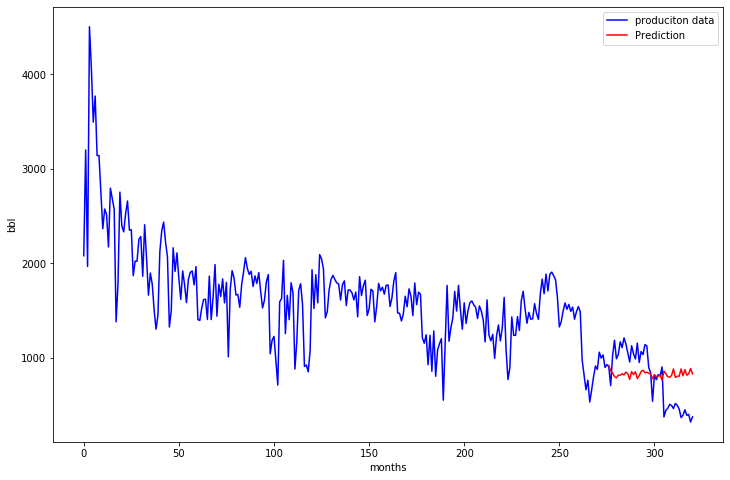

In [48]:
plt.figure(figsize=(12, 8))
xhat = range(len(time)-45, len(time))
yhat_array = CNN_prediction.reshape(-1,1)
plt.plot(time, series,'b-', label = 'produciton data')
plt.plot(xhat, yhat_array, 'r-', label='Prediction')
plt.xlabel('months')
plt.ylabel('bbl')
plt.legend()
plt.show()

### CNN wiht LSTM Layers

In [85]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.2),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])

Epoch 1/500
2/2 [==============================] - 0s 6ms/step - loss: 1657.3514 - mae: 1657.8514
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - loss: 1657.2260 - mae: 1657.7260
Epoch 3/500
2/2 [==============================] - 0s 3ms/step - loss: 1656.7028 - mae: 1657.2029
Epoch 4/500
2/2 [==============================] - 0s 3ms/step - loss: 1655.5194 - mae: 1656.0193
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - loss: 1654.9630 - mae: 1655.4629
Epoch 6/500
2/2 [==============================] - 0s 3ms/step - loss: 1653.7123 - mae: 1654.2123
Epoch 7/500
2/2 [==============================] - 0s 3ms/step - loss: 1652.0970 - mae: 1652.5970
Epoch 8/500
2/2 [==============================] - 0s 3ms/step - loss: 1649.8464 - mae: 1650.3464
Epoch 9/500
2/2 [==============================] - 0s 3ms/step - loss: 1647.0826 - mae: 1647.5826
Epoch 10/500
2/2 [==============================] - 0s 3ms/step - loss: 1645.1320 - mae: 1645.6320
Epoch 11/500
2/2 [=

2/2 [==============================] - 0s 4ms/step - loss: 349.7373 - mae: 350.2370
Epoch 85/500
2/2 [==============================] - 0s 4ms/step - loss: 354.1142 - mae: 354.6137
Epoch 86/500
2/2 [==============================] - 0s 3ms/step - loss: 347.6973 - mae: 348.1971
Epoch 87/500
2/2 [==============================] - 0s 3ms/step - loss: 343.8897 - mae: 344.3895
Epoch 88/500
2/2 [==============================] - 0s 3ms/step - loss: 346.7193 - mae: 347.2191
Epoch 89/500
2/2 [==============================] - 0s 3ms/step - loss: 343.9025 - mae: 344.4022
Epoch 90/500
2/2 [==============================] - 0s 3ms/step - loss: 340.9411 - mae: 341.4405
Epoch 91/500
2/2 [==============================] - 0s 2ms/step - loss: 337.2490 - mae: 337.7487
Epoch 92/500
2/2 [==============================] - 0s 3ms/step - loss: 336.8690 - mae: 337.3683
Epoch 93/500
2/2 [==============================] - 0s 3ms/step - loss: 331.7096 - mae: 332.2094
Epoch 94/500
2/2 [=========================

2/2 [==============================] - 0s 3ms/step - loss: 73839.4609 - mae: 73839.9688
Epoch 168/500
2/2 [==============================] - 0s 3ms/step - loss: 93129.8828 - mae: 93130.3906
Epoch 169/500
2/2 [==============================] - 0s 3ms/step - loss: 78501.8281 - mae: 78502.3359
Epoch 170/500
2/2 [==============================] - 0s 3ms/step - loss: 130830.3516 - mae: 130830.8516
Epoch 171/500
2/2 [==============================] - 0s 3ms/step - loss: 101952.4297 - mae: 101952.9219
Epoch 172/500
2/2 [==============================] - 0s 3ms/step - loss: 110011.4766 - mae: 110011.9766
Epoch 173/500
2/2 [==============================] - 0s 3ms/step - loss: 218898.2500 - mae: 218898.7500
Epoch 174/500
2/2 [==============================] - 0s 3ms/step - loss: 108286.0156 - mae: 108286.5234
Epoch 175/500
2/2 [==============================] - 0s 3ms/step - loss: 37440.3281 - mae: 37440.8281
Epoch 176/500
2/2 [==============================] - 0s 4ms/step - loss: 53932.8164 - 

2/2 [==============================] - 0s 3ms/step - loss: 107994184.0000 - mae: 107994176.0000
Epoch 245/500
2/2 [==============================] - 0s 2ms/step - loss: 154644432.0000 - mae: 154644432.0000
Epoch 246/500
2/2 [==============================] - 0s 3ms/step - loss: 196954896.0000 - mae: 196954880.0000
Epoch 247/500
2/2 [==============================] - 0s 3ms/step - loss: 236302112.0000 - mae: 236302112.0000
Epoch 248/500
2/2 [==============================] - 0s 3ms/step - loss: 273868384.0000 - mae: 273868384.0000
Epoch 249/500
2/2 [==============================] - 0s 3ms/step - loss: 648956608.0000 - mae: 648956544.0000
Epoch 250/500
2/2 [==============================] - 0s 3ms/step - loss: 1123914240.0000 - mae: 1123914112.0000
Epoch 251/500
2/2 [==============================] - 0s 3ms/step - loss: 1569149824.0000 - mae: 1569149952.0000
Epoch 252/500
2/2 [==============================] - 0s 3ms/step - loss: 1072253760.0000 - mae: 1072253696.0000
Epoch 253/500
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 555097260032.0000 - mae: 555097260032.0000
Epoch 316/500
2/2 [==============================] - 0s 3ms/step - loss: 665992626176.0000 - mae: 665992691712.0000
Epoch 317/500
2/2 [==============================] - 0s 3ms/step - loss: 771868983296.0000 - mae: 771868983296.0000
Epoch 318/500
2/2 [==============================] - 0s 3ms/step - loss: 1829005164544.0000 - mae: 1829005295616.0000
Epoch 319/500
2/2 [==============================] - 0s 3ms/step - loss: 3167683870720.0000 - mae: 3167683608576.0000
Epoch 320/500
2/2 [==============================] - 0s 3ms/step - loss: 4422401785856.0000 - mae: 4422401785856.0000
Epoch 321/500
2/2 [==============================] - 0s 3ms/step - loss: 3022019100672.0000 - mae: 3022019100672.0000
Epoch 322/500
2/2 [==============================] - 0s 3ms/step - loss: 3111300104192.0000 - mae: 3111300104192.0000
Epoch 323/500
2/2 [==============================] - 0s 3ms/step - loss: 665

2/2 [==============================] - 0s 3ms/step - loss: 1228393127346176.0000 - mae: 1228393127346176.0000
Epoch 384/500
2/2 [==============================] - 0s 3ms/step - loss: 1564476331524096.0000 - mae: 1564476331524096.0000
Epoch 385/500
2/2 [==============================] - 0s 3ms/step - loss: 1877022309613568.0000 - mae: 1877022175395840.0000
Epoch 386/500
2/2 [==============================] - 0s 3ms/step - loss: 2175421604954112.0000 - mae: 2175421604954112.0000
Epoch 387/500
2/2 [==============================] - 0s 3ms/step - loss: 5154836391657472.0000 - mae: 5154836391657472.0000
Epoch 388/500
2/2 [==============================] - 0s 3ms/step - loss: 8927739138539520.0000 - mae: 8927740212281344.0000
Epoch 389/500
2/2 [==============================] - 0s 3ms/step - loss: 12464028378988544.0000 - mae: 12464028378988544.0000
Epoch 390/500
2/2 [==============================] - 0s 3ms/step - loss: 8517207373905920.0000 - mae: 8517207373905920.0000
Epoch 391/500
2/2 [=

2/2 [==============================] - 0s 3ms/step - loss: 5174832784430071808.0000 - mae: 5174833334185885696.0000
Epoch 448/500
2/2 [==============================] - 0s 3ms/step - loss: 6896333741992443904.0000 - mae: 6896333741992443904.0000
Epoch 449/500
2/2 [==============================] - 0s 5ms/step - loss: 15169601288611561472.0000 - mae: 15169601288611561472.0000
Epoch 450/500
2/2 [==============================] - 0s 4ms/step - loss: 5438120189549871104.0000 - mae: 5438120189549871104.0000
Epoch 451/500
2/2 [==============================] - 0s 4ms/step - loss: 2417714194171297792.0000 - mae: 2417714194171297792.0000
Epoch 452/500
2/2 [==============================] - 0s 3ms/step - loss: 3462082565035261952.0000 - mae: 3462082290157355008.0000
Epoch 453/500
2/2 [==============================] - 0s 4ms/step - loss: 4409295064811962368.0000 - mae: 4409295339689869312.0000
Epoch 454/500
2/2 [==============================] - 0s 4ms/step - loss: 5290169355160518656.0000 - ma

[1e-08, 1, 0, 5000]

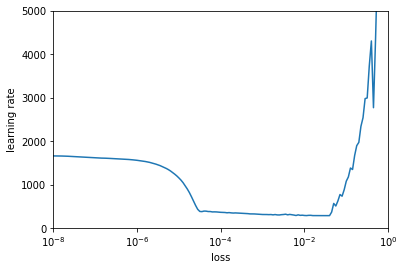

In [87]:

plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('loss')
plt.ylabel('learning rate')
plt.axis([1e-8, 1, 0, 5000])

In [92]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

In [93]:

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.2),
  keras.layers.Dense(1)

])
optimizer = keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'C:/Users/Preston/Desktop/multi-step-CNN-tf.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


In [94]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = model.fit(train_set, epochs=700,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/700
2/2 [==============================] - 1s 265ms/step - loss: 1617.6223 - mae: 1618.1223 - val_loss: 822.4542 - val_mae: 822.9542
Epoch 2/700
2/2 [==============================] - 0s 52ms/step - loss: 1617.4447 - mae: 1617.9447 - val_loss: 822.3176 - val_mae: 822.8176
Epoch 3/700
2/2 [==============================] - 0s 42ms/step - loss: 1617.3240 - mae: 1617.8240 - val_loss: 822.2117 - val_mae: 822.7117
Epoch 4/700
2/2 [==============================] - 0s 45ms/step - loss: 1617.1854 - mae: 1617.6854 - val_loss: 822.0104 - val_mae: 822.5104
Epoch 5/700
2/2 [==============================] - 0s 50ms/step - loss: 1616.9946 - mae: 1617.4945 - val_loss: 821.9047 - val_mae: 822.4047
Epoch 6/700
2/2 [==============================] - 0s 54ms/step - loss: 1616.8860 - mae: 1617.3859 - val_loss: 821.7802 - val_mae: 822.2802
Epoch 7/700
2/2 [==============================] - 0s 59ms/step - loss: 1616.7511 - mae: 1617.2511 - val_loss: 821.6371 - val_mae: 822.1371
Epoch 8/700
2/2 [==

2/2 [==============================] - 0s 48ms/step - loss: 1602.6582 - mae: 1603.1583 - val_loss: 807.2859 - val_mae: 807.7859
Epoch 60/700
2/2 [==============================] - 0s 54ms/step - loss: 1602.1835 - mae: 1602.6833 - val_loss: 806.7978 - val_mae: 807.2978
Epoch 61/700
2/2 [==============================] - 0s 63ms/step - loss: 1601.6714 - mae: 1602.1714 - val_loss: 806.2931 - val_mae: 806.7931
Epoch 62/700
2/2 [==============================] - 1s 471ms/step - loss: 1601.2023 - mae: 1601.7023 - val_loss: 805.7942 - val_mae: 806.2942
Epoch 63/700
2/2 [==============================] - 0s 52ms/step - loss: 1600.6923 - mae: 1601.1921 - val_loss: 805.2903 - val_mae: 805.7903
Epoch 64/700
2/2 [==============================] - 0s 62ms/step - loss: 1600.1443 - mae: 1600.6444 - val_loss: 804.7825 - val_mae: 805.2825
Epoch 65/700
2/2 [==============================] - 0s 50ms/step - loss: 1599.6760 - mae: 1600.1760 - val_loss: 804.2721 - val_mae: 804.7721
Epoch 66/700
2/2 [=======

2/2 [==============================] - 0s 114ms/step - loss: 1571.0405 - mae: 1571.5404 - val_loss: 775.6022 - val_mae: 776.1022
Epoch 118/700
2/2 [==============================] - 0s 94ms/step - loss: 1570.4674 - mae: 1570.9674 - val_loss: 775.0165 - val_mae: 775.5165
Epoch 119/700
2/2 [==============================] - 0s 56ms/step - loss: 1569.8773 - mae: 1570.3774 - val_loss: 774.4297 - val_mae: 774.9297
Epoch 120/700
2/2 [==============================] - 0s 47ms/step - loss: 1569.2428 - mae: 1569.7428 - val_loss: 773.8412 - val_mae: 774.3412
Epoch 121/700
2/2 [==============================] - 0s 36ms/step - loss: 1568.6266 - mae: 1569.1266 - val_loss: 773.2514 - val_mae: 773.7514
Epoch 122/700
2/2 [==============================] - 0s 58ms/step - loss: 1568.1760 - mae: 1568.6759 - val_loss: 772.6603 - val_mae: 773.1603
Epoch 123/700
2/2 [==============================] - 0s 54ms/step - loss: 1567.5217 - mae: 1568.0217 - val_loss: 772.0681 - val_mae: 772.5681
Epoch 124/700
2/2 [

Epoch 175/700
2/2 [==============================] - 0s 45ms/step - loss: 1535.8372 - mae: 1536.3372 - val_loss: 740.4594 - val_mae: 740.9594
Epoch 176/700
2/2 [==============================] - 0s 46ms/step - loss: 1535.3948 - mae: 1535.8947 - val_loss: 739.8428 - val_mae: 740.3428
Epoch 177/700
2/2 [==============================] - 0s 68ms/step - loss: 1534.7490 - mae: 1535.2490 - val_loss: 739.2260 - val_mae: 739.7260
Epoch 178/700
2/2 [==============================] - 0s 60ms/step - loss: 1534.1271 - mae: 1534.6270 - val_loss: 738.6088 - val_mae: 739.1088
Epoch 179/700
2/2 [==============================] - 0s 61ms/step - loss: 1533.4410 - mae: 1533.9410 - val_loss: 737.9912 - val_mae: 738.4912
Epoch 180/700
2/2 [==============================] - 0s 47ms/step - loss: 1532.8530 - mae: 1533.3531 - val_loss: 737.3731 - val_mae: 737.8731
Epoch 181/700
2/2 [==============================] - 0s 50ms/step - loss: 1532.3666 - mae: 1532.8667 - val_loss: 736.7548 - val_mae: 737.2548
Epoch 

2/2 [==============================] - 0s 54ms/step - loss: 1500.1536 - mae: 1500.6536 - val_loss: 704.5028 - val_mae: 705.0028
Epoch 233/700
2/2 [==============================] - 0s 61ms/step - loss: 1499.3788 - mae: 1499.8788 - val_loss: 703.8648 - val_mae: 704.3648
Epoch 234/700
2/2 [==============================] - 0s 57ms/step - loss: 1498.5333 - mae: 1499.0333 - val_loss: 703.2265 - val_mae: 703.7265
Epoch 235/700
2/2 [==============================] - 0s 57ms/step - loss: 1498.1632 - mae: 1498.6632 - val_loss: 702.5881 - val_mae: 703.0881
Epoch 236/700
2/2 [==============================] - 1s 263ms/step - loss: 1497.4178 - mae: 1497.9178 - val_loss: 701.9495 - val_mae: 702.4495
Epoch 237/700
2/2 [==============================] - 0s 58ms/step - loss: 1496.7755 - mae: 1497.2756 - val_loss: 701.3109 - val_mae: 701.8109
Epoch 238/700
2/2 [==============================] - 0s 156ms/step - loss: 1496.2729 - mae: 1496.7731 - val_loss: 700.6723 - val_mae: 701.1723
Epoch 239/700
2/2 

Epoch 290/700
2/2 [==============================] - 0s 46ms/step - loss: 1463.0306 - mae: 1463.5306 - val_loss: 667.3837 - val_mae: 667.8837
Epoch 291/700
2/2 [==============================] - 0s 56ms/step - loss: 1462.2454 - mae: 1462.7454 - val_loss: 666.7421 - val_mae: 667.2421
Epoch 292/700
2/2 [==============================] - 0s 49ms/step - loss: 1461.4651 - mae: 1461.9648 - val_loss: 666.1003 - val_mae: 666.6003
Epoch 293/700
2/2 [==============================] - 0s 50ms/step - loss: 1460.8710 - mae: 1461.3708 - val_loss: 665.4584 - val_mae: 665.9584
Epoch 294/700
2/2 [==============================] - 0s 59ms/step - loss: 1460.1934 - mae: 1460.6934 - val_loss: 664.8164 - val_mae: 665.3164
Epoch 295/700
2/2 [==============================] - 0s 47ms/step - loss: 1459.7135 - mae: 1460.2136 - val_loss: 664.1744 - val_mae: 664.6744
Epoch 296/700
2/2 [==============================] - 0s 37ms/step - loss: 1459.1885 - mae: 1459.6886 - val_loss: 663.5324 - val_mae: 664.0324
Epoch 

2/2 [==============================] - 0s 59ms/step - loss: 1425.9548 - mae: 1426.4550 - val_loss: 630.7430 - val_mae: 631.2430
Epoch 348/700
2/2 [==============================] - 0s 53ms/step - loss: 1425.3638 - mae: 1425.8636 - val_loss: 630.0989 - val_mae: 630.5989
Epoch 349/700
2/2 [==============================] - 0s 46ms/step - loss: 1425.1859 - mae: 1425.6860 - val_loss: 629.4548 - val_mae: 629.9548
Epoch 350/700
2/2 [==============================] - 1s 394ms/step - loss: 1424.2032 - mae: 1424.7031 - val_loss: 628.8107 - val_mae: 629.3107
Epoch 351/700
2/2 [==============================] - 0s 42ms/step - loss: 1423.7095 - mae: 1424.2095 - val_loss: 628.1667 - val_mae: 628.6667
Epoch 352/700
2/2 [==============================] - 0s 54ms/step - loss: 1422.9783 - mae: 1423.4784 - val_loss: 627.5226 - val_mae: 628.0226
Epoch 353/700
2/2 [==============================] - 0s 60ms/step - loss: 1422.4242 - mae: 1422.9243 - val_loss: 626.8787 - val_mae: 627.3787
Epoch 354/700
2/2 [

Epoch 405/700
2/2 [==============================] - 0s 53ms/step - loss: 1388.5186 - mae: 1389.0186 - val_loss: 593.3560 - val_mae: 593.8560
Epoch 406/700
2/2 [==============================] - 0s 53ms/step - loss: 1387.6917 - mae: 1388.1917 - val_loss: 592.7104 - val_mae: 593.2104
Epoch 407/700
2/2 [==============================] - 0s 55ms/step - loss: 1387.7128 - mae: 1388.2128 - val_loss: 592.0650 - val_mae: 592.5650
Epoch 408/700
2/2 [==============================] - 0s 50ms/step - loss: 1386.8247 - mae: 1387.3247 - val_loss: 591.4196 - val_mae: 591.9196
Epoch 409/700
2/2 [==============================] - 0s 50ms/step - loss: 1386.6598 - mae: 1387.1599 - val_loss: 590.7743 - val_mae: 591.2743
Epoch 410/700
2/2 [==============================] - 1s 252ms/step - loss: 1385.5613 - mae: 1386.0613 - val_loss: 590.1290 - val_mae: 590.6290
Epoch 411/700
2/2 [==============================] - 0s 53ms/step - loss: 1384.9785 - mae: 1385.4785 - val_loss: 589.4836 - val_mae: 589.9836
Epoch

2/2 [==============================] - 0s 71ms/step - loss: 1352.2388 - mae: 1352.7388 - val_loss: 556.5555 - val_mae: 557.0555
Epoch 463/700
2/2 [==============================] - 0s 62ms/step - loss: 1351.3741 - mae: 1351.8741 - val_loss: 555.9098 - val_mae: 556.4098
Epoch 464/700
2/2 [==============================] - 0s 60ms/step - loss: 1350.2555 - mae: 1350.7555 - val_loss: 555.2636 - val_mae: 555.7636
Epoch 465/700
2/2 [==============================] - 0s 133ms/step - loss: 1350.2720 - mae: 1350.7720 - val_loss: 554.6176 - val_mae: 555.1176
Epoch 466/700
2/2 [==============================] - 0s 56ms/step - loss: 1349.5105 - mae: 1350.0105 - val_loss: 553.9716 - val_mae: 554.4716
Epoch 467/700
2/2 [==============================] - 0s 127ms/step - loss: 1349.0988 - mae: 1349.5988 - val_loss: 553.3256 - val_mae: 553.8256
Epoch 468/700
2/2 [==============================] - 0s 50ms/step - loss: 1347.9335 - mae: 1348.4335 - val_loss: 552.6796 - val_mae: 553.1796
Epoch 469/700
2/2 

Epoch 520/700
2/2 [==============================] - 0s 49ms/step - loss: 1314.7378 - mae: 1315.2378 - val_loss: 519.0647 - val_mae: 519.5647
Epoch 521/700
2/2 [==============================] - 0s 61ms/step - loss: 1313.7625 - mae: 1314.2625 - val_loss: 518.4177 - val_mae: 518.9177
Epoch 522/700
2/2 [==============================] - 0s 50ms/step - loss: 1313.3325 - mae: 1313.8325 - val_loss: 517.7709 - val_mae: 518.2709
Epoch 523/700
2/2 [==============================] - 0s 54ms/step - loss: 1312.4751 - mae: 1312.9751 - val_loss: 517.1238 - val_mae: 517.6238
Epoch 524/700
2/2 [==============================] - 0s 50ms/step - loss: 1311.4551 - mae: 1311.9551 - val_loss: 516.4769 - val_mae: 516.9769
Epoch 525/700
2/2 [==============================] - 1s 526ms/step - loss: 1311.1781 - mae: 1311.6781 - val_loss: 515.8297 - val_mae: 516.3297
Epoch 526/700
2/2 [==============================] - 0s 52ms/step - loss: 1309.9882 - mae: 1310.4882 - val_loss: 515.1824 - val_mae: 515.6824
Epoch

2/2 [==============================] - 0s 48ms/step - loss: 1278.0660 - mae: 1278.5660 - val_loss: 482.3768 - val_mae: 482.8768
Epoch 578/700
2/2 [==============================] - 0s 56ms/step - loss: 1276.9774 - mae: 1277.4774 - val_loss: 481.7351 - val_mae: 482.2351
Epoch 579/700
2/2 [==============================] - 0s 59ms/step - loss: 1276.5077 - mae: 1277.0076 - val_loss: 481.0934 - val_mae: 481.5934
Epoch 580/700
2/2 [==============================] - 1s 263ms/step - loss: 1276.0426 - mae: 1276.5426 - val_loss: 480.4518 - val_mae: 480.9518
Epoch 581/700
2/2 [==============================] - 0s 55ms/step - loss: 1274.6934 - mae: 1275.1935 - val_loss: 479.8100 - val_mae: 480.3100
Epoch 582/700
2/2 [==============================] - 0s 53ms/step - loss: 1274.7687 - mae: 1275.2686 - val_loss: 479.1684 - val_mae: 479.6684
Epoch 583/700
2/2 [==============================] - 0s 47ms/step - loss: 1273.7194 - mae: 1274.2194 - val_loss: 478.5266 - val_mae: 479.0266
Epoch 584/700
2/2 [

Epoch 635/700
2/2 [==============================] - 0s 57ms/step - loss: 1240.5319 - mae: 1241.0319 - val_loss: 446.0875 - val_mae: 446.5875
Epoch 636/700
2/2 [==============================] - 0s 48ms/step - loss: 1239.3781 - mae: 1239.8781 - val_loss: 445.5110 - val_mae: 446.0110
Epoch 637/700
2/2 [==============================] - 0s 49ms/step - loss: 1239.2880 - mae: 1239.7881 - val_loss: 444.9347 - val_mae: 445.4347
Epoch 638/700
2/2 [==============================] - 0s 52ms/step - loss: 1238.3986 - mae: 1238.8987 - val_loss: 444.3583 - val_mae: 444.8583
Epoch 639/700
2/2 [==============================] - 0s 51ms/step - loss: 1238.3665 - mae: 1238.8665 - val_loss: 443.7820 - val_mae: 444.2820
Epoch 640/700
2/2 [==============================] - 0s 49ms/step - loss: 1236.8799 - mae: 1237.3799 - val_loss: 443.2056 - val_mae: 443.7056
Epoch 641/700
2/2 [==============================] - 0s 55ms/step - loss: 1235.5890 - mae: 1236.0890 - val_loss: 442.6291 - val_mae: 443.1291
Epoch 

2/2 [==============================] - 0s 46ms/step - loss: 1203.3505 - mae: 1203.8505 - val_loss: 414.5468 - val_mae: 415.0468
Epoch 693/700
2/2 [==============================] - 1s 357ms/step - loss: 1202.2902 - mae: 1202.7902 - val_loss: 414.0049 - val_mae: 414.5049
Epoch 694/700
2/2 [==============================] - 0s 135ms/step - loss: 1201.5629 - mae: 1202.0629 - val_loss: 413.4631 - val_mae: 413.9631
Epoch 695/700
2/2 [==============================] - 0s 47ms/step - loss: 1200.9421 - mae: 1201.4420 - val_loss: 412.9212 - val_mae: 413.4212
Epoch 696/700
2/2 [==============================] - 0s 53ms/step - loss: 1199.9514 - mae: 1200.4514 - val_loss: 412.3792 - val_mae: 412.8792
Epoch 697/700
2/2 [==============================] - 0s 63ms/step - loss: 1199.4441 - mae: 1199.9442 - val_loss: 411.8371 - val_mae: 412.3371
Epoch 698/700
2/2 [==============================] - 0s 54ms/step - loss: 1199.2804 - mae: 1199.7803 - val_loss: 411.2951 - val_mae: 411.7951
Epoch 699/700
2/2 

In [96]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
695,1199.951416,1200.451416,412.379242,412.879242,695
696,1199.444092,1199.944214,411.837128,412.337128,696
697,1199.280396,1199.780273,411.295135,411.795135,697
698,1198.110352,1198.610352,410.753113,411.253113,698
699,1197.475098,1197.975098,410.211029,410.711029,699


In [97]:
cnn_model = keras.models.load_model('C:/Users/Preston/Desktop/multi-step-CNN-tf.h5')

In [98]:
rnn_forecast = model_forecast(cnn_model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

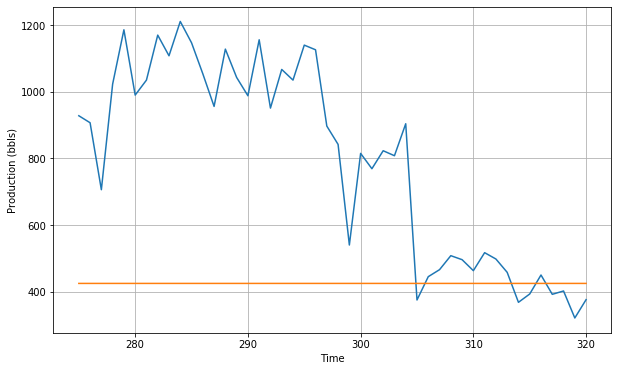

In [99]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

### Wavenet Type Archetecture


In [125]:
# Determining Learning Rate

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-8)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
2/2 [==============================] - 0s 79ms/step - loss: 1643.8745 - mae: 1644.3744
Epoch 2/200
2/2 [==============================] - 0s 2ms/step - loss: 1640.3618 - mae: 1640.8618
Epoch 3/200
2/2 [==============================] - 0s 2ms/step - loss: 1636.6090 - mae: 1637.1091
Epoch 4/200
2/2 [==============================] - 0s 2ms/step - loss: 1632.6355 - mae: 1633.1355
Epoch 5/200
2/2 [==============================] - 0s 2ms/step - loss: 1628.5541 - mae: 1629.0542
Epoch 6/200
2/2 [==============================] - 0s 2ms/step - loss: 1624.4307 - mae: 1624.9307
Epoch 7/200
2/2 [==============================] - 0s 3ms/step - loss: 1620.2625 - mae: 1620.7625
Epoch 8/200
2/2 [==============================] - 0s 2ms/step - loss: 1616.0490 - mae: 1616.5488
Epoch 9/200
2/2 [==============================] - 0s 2ms/step - loss: 1611.8643 - mae: 1612.3643
Epoch 10/200
2/2 [==============================] - 0s 2ms/step - loss: 1607.6035 - mae: 1608.1034
Epoch 11/200
2/2 [

Epoch 85/200
2/2 [==============================] - 0s 2ms/step - loss: 566.2822 - mae: 566.7820
Epoch 86/200
2/2 [==============================] - 0s 2ms/step - loss: 560.4409 - mae: 560.9406
Epoch 87/200
2/2 [==============================] - 0s 2ms/step - loss: 1064.3695 - mae: 1064.8694
Epoch 88/200
2/2 [==============================] - 0s 2ms/step - loss: 403.5524 - mae: 404.0520
Epoch 89/200
2/2 [==============================] - 0s 2ms/step - loss: 558.8119 - mae: 559.3117
Epoch 90/200
2/2 [==============================] - 0s 2ms/step - loss: 666.4690 - mae: 666.9690
Epoch 91/200
2/2 [==============================] - 0s 3ms/step - loss: 996.6465 - mae: 997.1465
Epoch 92/200
2/2 [==============================] - 0s 3ms/step - loss: 764.9680 - mae: 765.4679
Epoch 93/200
2/2 [==============================] - 0s 3ms/step - loss: 687.4117 - mae: 687.9111
Epoch 94/200
2/2 [==============================] - 0s 3ms/step - loss: 538.1621 - mae: 538.6619
Epoch 95/200
2/2 [==========

2/2 [==============================] - 0s 2ms/step - loss: 613.0372 - mae: 613.5372
Epoch 168/200
2/2 [==============================] - 0s 2ms/step - loss: 547.9075 - mae: 548.4075
Epoch 169/200
2/2 [==============================] - 0s 3ms/step - loss: 482.0946 - mae: 482.5946
Epoch 170/200
2/2 [==============================] - 0s 2ms/step - loss: 420.9802 - mae: 421.4802
Epoch 171/200
2/2 [==============================] - 0s 2ms/step - loss: 366.3788 - mae: 366.8788
Epoch 172/200
2/2 [==============================] - 0s 2ms/step - loss: 321.7548 - mae: 322.2543
Epoch 173/200
2/2 [==============================] - 0s 2ms/step - loss: 293.9872 - mae: 294.4873
Epoch 174/200
2/2 [==============================] - 0s 2ms/step - loss: 285.0131 - mae: 285.5128
Epoch 175/200
2/2 [==============================] - 0s 2ms/step - loss: 290.8042 - mae: 291.3020
Epoch 176/200
2/2 [==============================] - 0s 2ms/step - loss: 303.7147 - mae: 304.2141
Epoch 177/200
2/2 [===============

[1e-08, 1, 0, 5000]

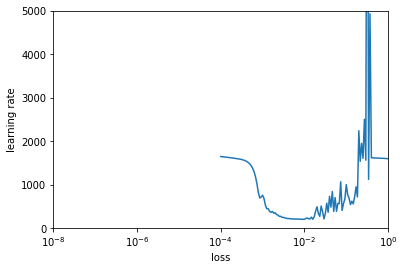

In [126]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('loss')
plt.ylabel('learning rate')
plt.axis([1e-8, 1, 0, 5000])

In [131]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

In [132]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=3,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'C:/Users/Preston/Desktop/multi-step-CNN-wave.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


In [133]:
history = model.fit(train_set, epochs=700,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/700
2/2 [==============================] - 0s 184ms/step - loss: 1597.2208 - mae: 1597.7208 - val_loss: 801.7490 - val_mae: 802.2490
Epoch 2/700
2/2 [==============================] - 0s 68ms/step - loss: 1575.9623 - mae: 1576.4623 - val_loss: 784.3901 - val_mae: 784.8901
Epoch 3/700
2/2 [==============================] - 0s 64ms/step - loss: 1544.6521 - mae: 1545.1521 - val_loss: 759.9279 - val_mae: 760.4279
Epoch 4/700
2/2 [==============================] - 1s 510ms/step - loss: 1500.1074 - mae: 1500.6075 - val_loss: 725.5848 - val_mae: 726.0848
Epoch 5/700
2/2 [==============================] - 0s 104ms/step - loss: 1437.9635 - mae: 1438.4636 - val_loss: 677.1985 - val_mae: 677.6985
Epoch 6/700
2/2 [==============================] - 0s 68ms/step - loss: 1350.4995 - mae: 1350.9995 - val_loss: 610.5278 - val_mae: 611.0278
Epoch 7/700
2/2 [==============================] - 0s 61ms/step - loss: 1229.2229 - mae: 1229.7230 - val_loss: 550.4438 - val_mae: 550.9431
Epoch 8/700
2/2 [

Epoch 60/700
2/2 [==============================] - 0s 66ms/step - loss: 203.1256 - mae: 203.6250 - val_loss: 136.2840 - val_mae: 136.7840
Epoch 61/700
2/2 [==============================] - 0s 15ms/step - loss: 202.8219 - mae: 203.3211 - val_loss: 137.1572 - val_mae: 137.6572
Epoch 62/700
2/2 [==============================] - 0s 15ms/step - loss: 202.4921 - mae: 202.9915 - val_loss: 136.5627 - val_mae: 137.0627
Epoch 63/700
2/2 [==============================] - 1s 378ms/step - loss: 202.2693 - mae: 202.7684 - val_loss: 135.9719 - val_mae: 136.4713
Epoch 64/700
2/2 [==============================] - 0s 70ms/step - loss: 201.9484 - mae: 202.4479 - val_loss: 134.4780 - val_mae: 134.9780
Epoch 65/700
2/2 [==============================] - 0s 14ms/step - loss: 201.7257 - mae: 202.2253 - val_loss: 135.5000 - val_mae: 135.9991
Epoch 66/700
2/2 [==============================] - 0s 16ms/step - loss: 201.8290 - mae: 202.3285 - val_loss: 135.0096 - val_mae: 135.5089
Epoch 67/700
2/2 [========

Epoch 119/700
2/2 [==============================] - 0s 64ms/step - loss: 189.3825 - mae: 189.8816 - val_loss: 116.1008 - val_mae: 116.5994
Epoch 120/700
2/2 [==============================] - 0s 14ms/step - loss: 189.3239 - mae: 189.8232 - val_loss: 117.7544 - val_mae: 118.2530
Epoch 121/700
2/2 [==============================] - 0s 14ms/step - loss: 189.1795 - mae: 189.6788 - val_loss: 116.2562 - val_mae: 116.7562
Epoch 122/700
2/2 [==============================] - 0s 13ms/step - loss: 188.9235 - mae: 189.4226 - val_loss: 117.5288 - val_mae: 118.0282
Epoch 123/700
2/2 [==============================] - 0s 64ms/step - loss: 188.7850 - mae: 189.2842 - val_loss: 115.5529 - val_mae: 116.0516
Epoch 124/700
2/2 [==============================] - 0s 14ms/step - loss: 188.7254 - mae: 189.2247 - val_loss: 115.9407 - val_mae: 116.4401
Epoch 125/700
2/2 [==============================] - 0s 16ms/step - loss: 188.5268 - mae: 189.0260 - val_loss: 116.0546 - val_mae: 116.5533
Epoch 126/700
2/2 [=

2/2 [==============================] - 0s 13ms/step - loss: 181.0724 - mae: 181.5715 - val_loss: 117.1222 - val_mae: 117.6211
Epoch 178/700
2/2 [==============================] - 0s 14ms/step - loss: 181.1970 - mae: 181.6961 - val_loss: 109.6259 - val_mae: 110.1240
Epoch 179/700
2/2 [==============================] - 0s 13ms/step - loss: 181.6140 - mae: 182.1131 - val_loss: 116.1788 - val_mae: 116.6769
Epoch 180/700
2/2 [==============================] - 0s 14ms/step - loss: 181.6023 - mae: 182.1016 - val_loss: 112.2761 - val_mae: 112.7749
Epoch 181/700
2/2 [==============================] - 0s 13ms/step - loss: 181.1016 - mae: 181.6004 - val_loss: 111.7956 - val_mae: 112.2943
Epoch 182/700
2/2 [==============================] - 0s 13ms/step - loss: 180.4038 - mae: 180.9026 - val_loss: 115.4005 - val_mae: 115.8991
Epoch 183/700
2/2 [==============================] - 0s 13ms/step - loss: 180.2700 - mae: 180.7690 - val_loss: 112.5441 - val_mae: 113.0435
Epoch 184/700
2/2 [===============

In [134]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
218,176.320511,176.819000,117.952965,118.451019,218
219,175.489197,175.987839,118.819786,119.316910,219
220,175.661575,176.160278,119.345917,119.844498,220
221,175.493713,175.991974,117.902908,118.401611,221
222,175.670380,176.169418,116.434044,116.932869,222


In [135]:
wave_model = keras.models.load_model('C:/Users/Preston/Desktop/multi-step-CNN-wave.h5')

In [136]:
wave_forecast = model_forecast(model, series[..., np.newaxis], window_size)
wave_forecast = wave_forecast[split_time - window_size:-1, -1, 0]

In [139]:
wave_forecast

array([ 913.31   ,  898.40894,  966.56915,  861.9454 ,  893.6649 ,
       1091.7041 ,  973.105  ,  944.6206 , 1008.8408 , 1045.6014 ,
       1080.039  , 1118.2667 , 1087.2136 , 1038.3091 , 1089.1371 ,
       1099.0397 , 1028.8771 , 1019.1879 , 1014.4143 , 1008.95874,
       1035.0978 , 1070.4731 , 1053.7229 ,  949.93054,  863.33984,
        696.60864,  911.7582 ,  819.85986,  802.9225 ,  813.62006,
        802.26465,  607.11914,  789.95074,  682.99036,  450.44394,
        582.8016 ,  625.0303 ,  499.43127,  573.2971 ,  518.53125,
        393.40997,  404.88797,  560.08374,  458.0232 ,  440.20358,
        424.09387], dtype=float32)

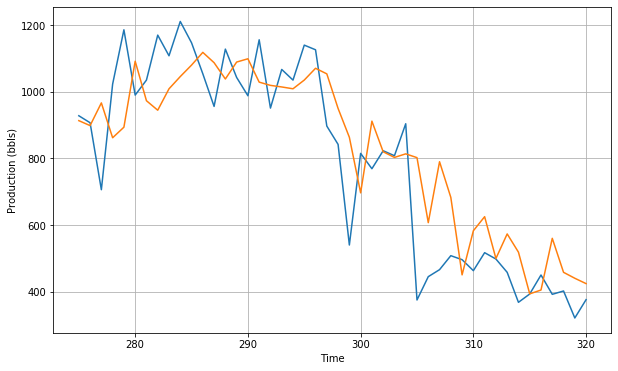

In [149]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, wave_forecast)

In [150]:
keras.metrics.mean_absolute_error(x_valid, wave_forecast).numpy()

116.262856

### Model Comparison

In [140]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


def stats(val, pred, label):
    MSE = mean_squared_error(val, pred)
    RMSE = MSE ** 0.5
    MAE = mean_absolute_error(val, pred)
    print(label, "RMSE: ", MSE)
    print(label, "MAE: ", MAE)
    return MSE, MAE

WaveCNN:  RMSE:  337832.77124696044
WaveCNN:  MAE:  528.8284693178923
CNN:  RMSE:  282310.6707733853
CNN:  MAE:  530.1476589626736
FB:  RMSE:  832935.3280663204
FB:  MAE:  904.4477656781252
ARPS:  RMSE:  179893.7293946931
ARPS:  MAE:  422.2191491116157


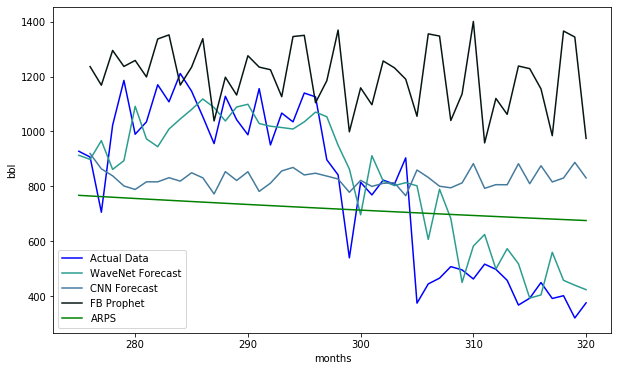

In [167]:
plt.figure(figsize=(10, 6))


plt.plot(time_valid, x_valid, label = "Actual Data", color="Blue")


plt.plot(time_valid, wave_forecast, label="WaveNet Forecast", color="#2a9d8f")
Wave_RMSE, Wave_MAE = stats(time_valid, wave_forecast, 'WaveCNN: ')
 

plt.plot(xhat, yhat_array, 'r-', label='CNN Forecast', color="#457b9d")
CNN_RMSE, CNN_MAE = stats(xhat, yhat_array, 'CNN: ')

plt.plot(xhat, fb_validation, 'r-', label='FB Prophet', color = "#061614")
FB_MSE, FB_MAE = stats(xhat, fb_validation, 'FB: ')

plt.plot(time_valid, ARPS_const[275:], label="ARPS", color="g")
ARPS_MSE, ARPS_MAE = stats(time_valid, ARPS_const[275:], 'ARPS: ')


plt.xlabel('months')
plt.ylabel('bbl')
plt.legend()
plt.show()


### Long Term Predictions